## Predicting Walmart Store Sales Forecasting

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
import plotly.express as px
# import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tqdm.notebook as tq

In [3]:
import pystan
pystan.__version__

'2.19.1.1'

In [5]:
from prophet import Prophet
#fbprophet.__version__

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [7]:
import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [8]:
features = pd.read_csv('features.csv')

In [9]:
features.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [10]:
train = pd.read_csv('train.csv')
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [11]:
test = pd.read_csv('test.csv')
test.head()

Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False

In [12]:
stores = pd.read_csv('stores.csv')
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

### Data Info

In [13]:
len(features)

8190

In [14]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [15]:
len(train)

421570

In [16]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [17]:
len(test)

115064

In [18]:
test.isnull().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

In [19]:
len(stores)

45

In [20]:
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

### Data Preparation

In [21]:
train['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [22]:
train['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [23]:
features[features.CPI.isnull()]

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169       1  2013-05-03        66.66       3.386    2298.63       2.00   
170       1  2013-05-10        63.90       3.392    4624.61      83.88   
171       1  2013-05-17        69.53       3.454   16170.50      92.00   
172       1  2013-05-24        77.19       3.494    7959.89     178.00   
173       1  2013-05-31        78.02       3.466    2369.77     142.45   
...     ...         ...          ...         ...        ...        ...   
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           NaN      False  
170       42.38    1618.31    8144.90  NaN           NaN      False  
171        8.32    4127.24    6206.97  NaN           NaN      False  
172     1621.47    3152.57    2938.70  NaN           NaN      False  
173      475.35      45.55    2056.84  NaN           NaN      False  
...         ...        ...        ...  ...           ...        ...  
8185       3.00    2449.97    3169.69  NaN           NaN      False  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False  

[585 rows x 12 columns]

In [24]:
data = train.merge(features, on = ['Store','Date','IsHoliday'], how = 'inner')
data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment  
0         8.106  
1         8.106  
2         8.106  
3         8.106  
4         8.106

In [25]:
data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64

In [26]:
final_data = data.merge(stores, on = ['Store'], how = 'inner')
final_data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [27]:
final_data.loc[final_data.MarkDown1.isnull(), 'MarkDown1'] = 0
final_data.loc[final_data.MarkDown2.isnull(), 'MarkDown2'] = 0
final_data.loc[final_data.MarkDown3.isnull(), 'MarkDown3'] = 0
final_data.loc[final_data.MarkDown4.isnull(), 'MarkDown4'] = 0
final_data.loc[final_data.MarkDown5.isnull(), 'MarkDown5'] = 0
final_data.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.096358   
2        0.0        0.0        0.0        0.0        0.0  211.096358   
3        0.0        0.0        0.0        0.0        0.0  211.096358   
4        0.0        0.0        0.0        0.0        0.0  211.096358   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [28]:
final_data.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [29]:
final_data.shape

(421570, 16)

In [30]:
final_data_copy = final_data.copy()
final_data_copy.shape

(421570, 16)

### Exploratory Data Analysis

#### Distribution of Store Types

In [31]:
typecounts = final_data.Type.value_counts().to_dict()
df = pd.DataFrame(list(typecounts.items()), columns=['Store_Type', 'Counts'])
fig = px.pie(df, values='Counts', names='Store_Type', color = 'Store_Type',
             title='Distribution of Store Types',labels='Store_Type', color_discrete_map={'A':'midnightblue',
                                 'B':'royalblue',
                                 'C':'lightskyblue',})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#### Average Sales Per Store Type

In [32]:
avgweeklysales = final_data.groupby('Type')['Weekly_Sales'].mean().to_dict()
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Store_Type', 'AvgSales'])

fig = px.bar(df, 
             x="Store_Type", 
             y="AvgSales",  
             title="Average Sales - Per Store Type",
             color_discrete_sequence=["#6495ED"])
fig.show()

#### Year wise average monthly sales

In [33]:
# Form Date, Year, Month, Week, Day
def split(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month']= data['Date'].dt.month
    data['Week'] = data['Date'].dt.week
    data['Day']  = data['Date'].dt.day
    return data
final_data=split(final_data)

In [34]:
sales2010 = final_data[(final_data.Year == 2010)].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2010 = pd.DataFrame(list(sales2010.items()), columns=['Month', 'AvgSales2010'])

sales2011 = final_data[final_data.Year == 2011].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2011 = pd.DataFrame(list(sales2011.items()), columns=['Month', 'AvgSales2011'])

sales2012 = final_data[final_data.Year == 2012].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2012 = pd.DataFrame(list(sales2012.items()), columns=['Month', 'AvgSales2012'])

monthly_merged = df2010.merge(df2011, how='right', on='Month').merge(df2012, how='left', on='Month')

# create trace1 
trace1 = go.Bar(
                x = df2010.Month,
                y = df2010.AvgSales2010,
                name = "AvgSales2010")
# create trace2 
trace2 = go.Bar(
                x = df2011.Month,
                y = df2011.AvgSales2011,
                name = "AvgSales2011")

# create trace3 
trace3 = go.Bar(
                x = df2012.Month,
                y = df2012.AvgSales2012,
                name = "AvgSales2012")
data = [trace1, trace2, trace3]
layout = go.Layout(barmode = "group",
                   xaxis_title="Month",
                   yaxis_title="Average Monthly Sales",)
fig = go.Figure(data = data, layout = layout)
fig.update_xaxes( dtick=1)
fig.show()

#### Average sales per store

In [35]:
store_sales = final_data.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)

fig = px.bar(store_sales, 
             x=store_sales.index, 
             y=store_sales.values,  
             title="Average Sales - Per Store",
             labels={'x':'Stores', 'y':'Sales'},
             color_discrete_sequence=["#FA8072"])

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

#### Average Store Sales for each year

In [36]:

store_sales_2010 = final_data[final_data.Year==2010].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2010_df = pd.DataFrame(list(store_sales_2010.items()), columns=['Store', 'AvgSales2010'])

store_sales_2011 = final_data[final_data.Year==2011].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2011_df = pd.DataFrame(list(store_sales_2011.items()), columns=['Store', 'AvgSales2011'])

store_sales_2012 = final_data[final_data.Year==2012].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2012_df = pd.DataFrame(list(store_sales_2012.items()), columns=['Store', 'AvgSales2012'])

fig = make_subplots(rows=3, cols=1, subplot_titles=("Average Store Sales 2010", "Average Store Sales 2011", "Average Store Sales 2012"))

fig.add_trace(go.Bar(x=store2010_df.Store, y=store2010_df.AvgSales2010, marker = {'color' : store2010_df.AvgSales2010,'colorscale': 'Viridis'}),1, 1)

fig.add_trace(go.Bar(x=store2011_df.Store, y=store2011_df.AvgSales2011, marker = {'color' : store2011_df.AvgSales2011,'colorscale': 'Viridis'}),2, 1)

fig.add_trace(go.Bar(x=store2012_df.Store, y=store2012_df.AvgSales2012, marker = {'color' : store2012_df.AvgSales2012,'colorscale': 'Viridis'}),3, 1)

fig.update_layout(coloraxis=dict(colorscale='Viridis'), showlegend=False, height=1500)

fig.update_xaxes(title_text="Store", row=1, col=1)
fig.update_xaxes(title_text="Store", row=2, col=1)
fig.update_xaxes(title_text="Store", row=3, col=1)

fig.update_yaxes(title_text="AvgSales", row=1, col=1)
fig.update_yaxes(title_text="AvgSales", row=2, col=1)
fig.update_yaxes(title_text="AvgSales", row=3, col=1)

fig.update_xaxes(tick0=1, dtick=1)
fig.show()

#### Average Sales for each Dept

In [37]:
dept_sales = final_data.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(dept_sales, 
             x=dept_sales.values, 
             y=dept_sales.index,  
             title="Average Sales - Per Department",
             labels={'x':'Dept', 'y':'Sales'},
             color_discrete_sequence=["salmon"],orientation='h', height=1200, width=1000)

fig.update_yaxes(tick0=1, dtick=1)

fig.show()

#### Sales for Holidays and Nonholidays

In [38]:

holiday_sales = final_data.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = final_data.IsHoliday.value_counts()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Holidays/Nonholidays Sales", "Holidays/Nonholidays Counts"))
fig.add_trace(go.Bar(x=holiday_sales.values, y=holiday_sales.index, orientation='h',),1, 1)

fig.add_trace(go.Bar(x=holiday_counts.values, y=holiday_counts.index, orientation='h',),1, 2)

fig.update_layout(coloraxis=dict(colorscale='viridis'), showlegend=False)
fig.show()

#### Size of Store and Sales Relationship

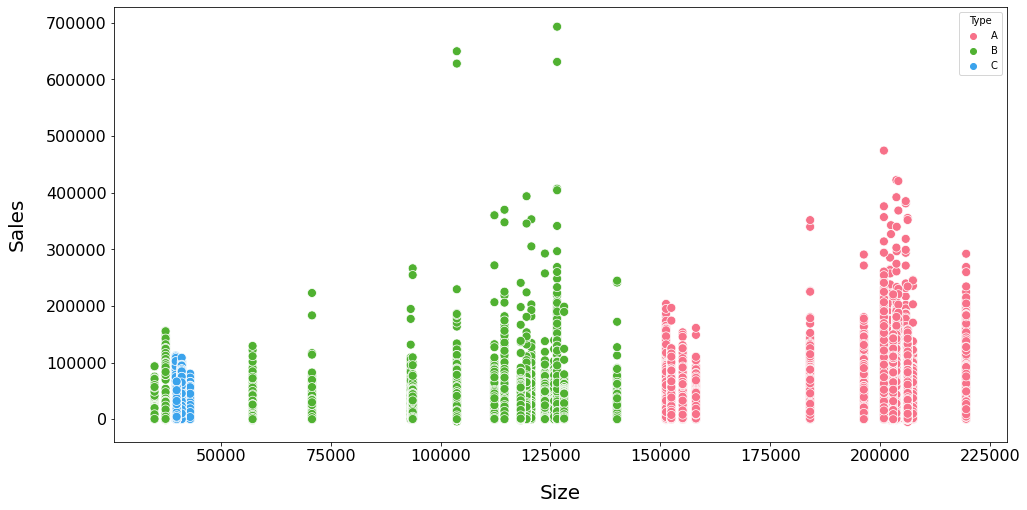

In [39]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.Size, y=final_data.Weekly_Sales, hue=final_data.Type, s=80, palette = "husl");

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Temperature and Sales Relationship

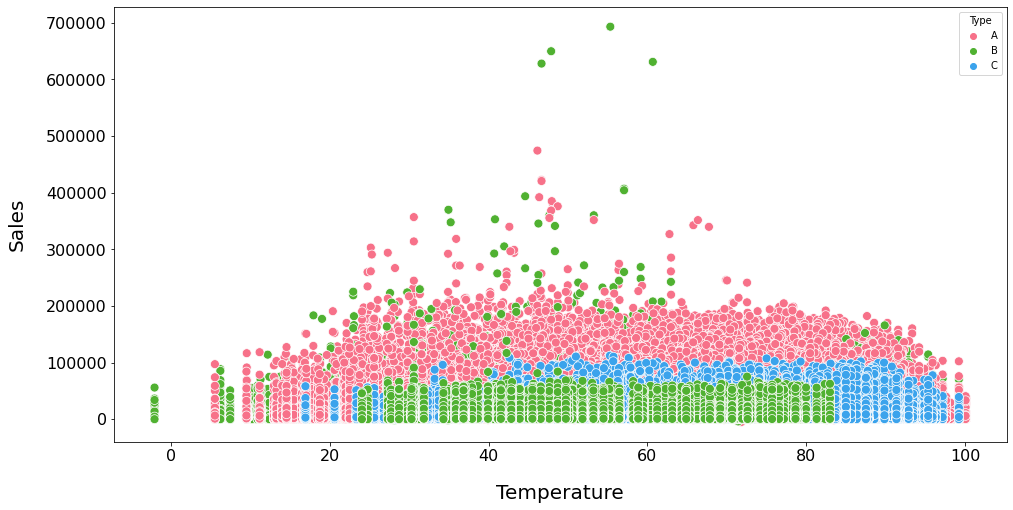

In [40]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.Temperature, y=final_data.Weekly_Sales, hue=final_data.Type, s=80,palette = "husl");

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Fuel Price and Sales Relationship

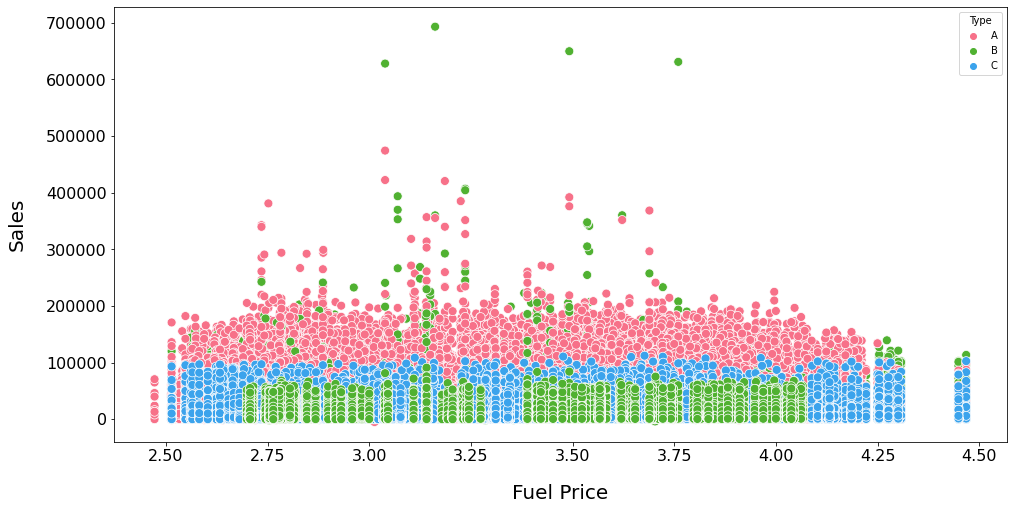

In [41]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.Fuel_Price, y=final_data.Weekly_Sales, hue=final_data.Type, s=80,palette = "husl");

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Fuel Price', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### CPI and Sales Relationship

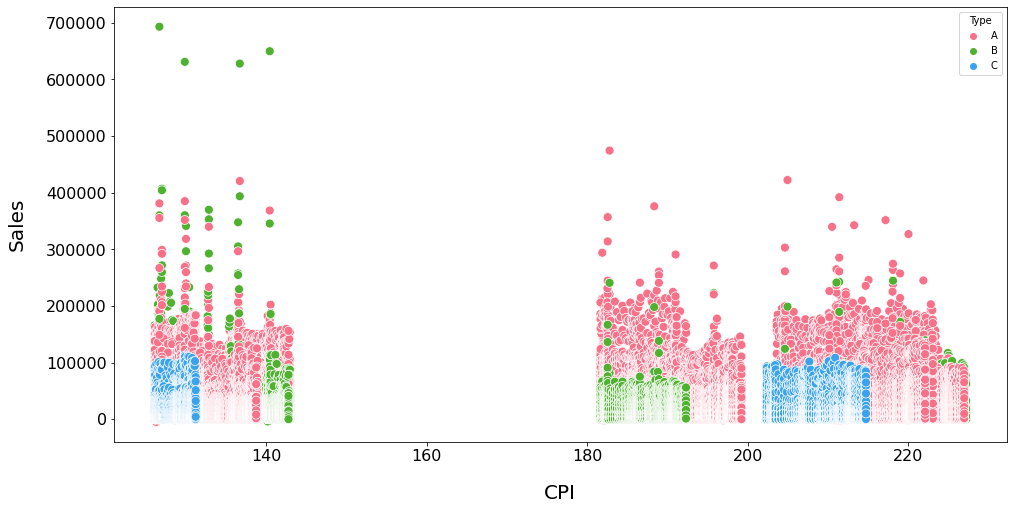

In [42]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.CPI, y=final_data.Weekly_Sales, hue=final_data.Type, s=80, palette = "husl");

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('CPI', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

#### Unemployment and Sales Relationship

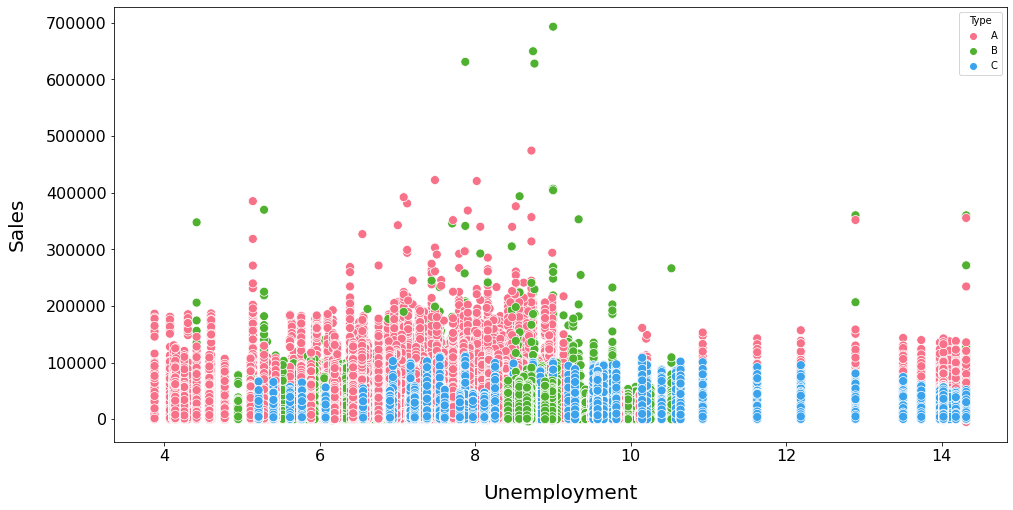

In [43]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=final_data.Unemployment, y=final_data.Weekly_Sales, hue=final_data.Type, s=80, palette = "husl");

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

### Facebook Prophet

#### Imputing null values

In [44]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [45]:
df = pd.DataFrame()
for i in tq.tqdm(range(1,46)):
    model=Prophet()
    filled=features[((features['Store']==i) & (features['Date']<'2013-05-03'))][['Date','CPI']]
    tserie = filled.rename(columns = {'Date': 'ds', 'CPI': 'y'}, inplace = False)
    tserie =tserie.sort_values(by=['ds'])
    tserie['ds'] = pd.to_datetime(tserie['ds'])
    model.fit(tserie)
    future_dates=model.make_future_dataframe(periods=13,freq = 'W',include_history =True)
    future_dates['ds'] = future_dates['ds'].apply(lambda x: x + timedelta(days=5))
    prediction=model.predict(future_dates)
    df=df.append(prediction)

df.reset_index(drop=True)
features['CPI1']=np.nan
for i,j in enumerate(df['yhat']):
    features['CPI1'].iloc[i]=j

features=features.drop(['CPI'],axis=1)
features = features.rename(columns = {'CPI1': 'CPI'})

  0%|          | 0/45 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.0214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1074.22    0.00310844       3812.31       0.997       0.997      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1104.83    0.00131302       8999.29           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1124.46   0.000419778       650.774           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1129.8   0.000355194       2565.89           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1131.84   0.000238196       1764.64           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1039.82   0.000347976       1358.24           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1061.98   0.000373459       1545.04           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1072.98    0.00394264       1975.49           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1086.2    0.00013886       632.634      0.3244      0.3244      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1128.99   0.000395945       2177.17           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.0215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1009.53     0.0124901       6946.61           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1079.03    0.00644744       5159.61       1.184      0.1184      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1100.17   0.000883359        2811.7           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1115.85    0.00114126        4496.1           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1121.14    0.00147115       934.223           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1023.13   0.000194641        758.58           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1037.51     0.0127839       8638.27           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1060.75   0.000175075       1084.73           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1067.66   0.000287455       3001.22      0.4413      0.4413      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1083.37     0.0138595       9109.09           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1058.45    0.00308786       16089.9           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1105.24   0.000407739       2844.83           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1128.19   0.000393813       4170.59           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1143.26     0.0085997       11514.9           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1147   5.62384e-05       888.999           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1149.4    0.00708568       37471.8      0.5076      0.5076      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1195.44   0.000169245       3264.17       3.418      0.3418      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1204.85   0.000739295       5649.24           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1217.85   0.000197047        5384.3           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1226.88   0.000277149       3621.02      0.3696      0.3696      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.0215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1069.64   0.000172828       1049.03      0.8894      0.8894      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1094.13    0.00233914       5936.36      0.3815           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1105.29    0.00637845       10554.9      0.5074           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1124.67   7.07511e-05       1611.39     0.01266           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1130.9   0.000974964       1216.25           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02151
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1061.44     0.0457253       33272.7           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1092.76    0.00401558       7084.85      0.4152      0.9967      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1107.76    0.00336103       10820.6      0.4027           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1126.27    0.00126663         10648           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1148.41   0.000238476       5032.65           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.0215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1009.53     0.0124901       6946.61           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1079.03    0.00644744       5159.61       1.184      0.1184      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1100.17   0.000883359        2811.7           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1115.85    0.00114126        4496.1           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1121.14    0.00147115       934.223           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01998
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1071.22     0.0730984       32634.1           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1136.38    0.00180543       5889.89           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1160.49    0.00121139       1790.85           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1172.22   0.000451425       12740.2      0.3188     0.03188      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1184.4   0.000215612       15744.8      0.2393      0.2393      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1149.4    0.00708568       37471.8      0.5076      0.5076      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1195.44   0.000169245       3264.17       3.418      0.3418      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1204.85   0.000739295       5649.24           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1217.85   0.000197047        5384.3           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1226.88   0.000277149       3621.02      0.3696      0.3696      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02104
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1057.95    0.00108991       12197.7           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1089.61   0.000482998       2670.89      0.3181      0.9702      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1105.48    0.00505559       3149.24           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1109.6    0.00314021       6715.03           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1115.92   0.000514014        2170.9       0.957       0.957      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1039.82   0.000347976       1358.24           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1061.98   0.000373459       1545.04           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1072.98    0.00394264       1975.49           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1086.2    0.00013886       632.634      0.3244      0.3244      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1128.99   0.000395945       2177.17           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1162.57    0.00473974       7337.03           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1191.25     0.0103952       14697.3           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1219.63    0.00307174       14925.2           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1229.7    0.00120316       7795.46           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1244.95   0.000451176       15742.6           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02104
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1057.95    0.00108991       12197.7           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1089.61   0.000482998       2670.89      0.3181      0.9702      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1105.48    0.00505559       3149.24           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1109.6    0.00314021       6715.03           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1115.92   0.000514014        2170.9       0.957       0.957      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1162.57    0.00473974       7337.03           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1191.25     0.0103952       14697.3           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1219.63    0.00307174       14925.2           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1229.7    0.00120316       7795.46           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1244.95   0.000451176       15742.6           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1039.82   0.000347976       1358.24           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1061.98   0.000373459       1545.04           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1072.98    0.00394264       1975.49           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1086.2    0.00013886       632.634      0.3244      0.3244      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1128.99   0.000395945       2177.17           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1039.82   0.000347976       1358.24           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1061.98   0.000373459       1545.04           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1072.98    0.00394264       1975.49           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1086.2    0.00013886       632.634      0.3244      0.3244      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1128.99   0.000395945       2177.17           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1149.4    0.00708568       37471.8      0.5076      0.5076      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1195.44   0.000169245       3264.17       3.418      0.3418      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1204.85   0.000739295       5649.24           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1217.85   0.000197047        5384.3           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1226.88   0.000277149       3621.02      0.3696      0.3696      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1162.57    0.00473974       7337.03           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1191.25     0.0103952       14697.3           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1219.63    0.00307174       14925.2           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1229.7    0.00120316       7795.46           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1244.95   0.000451176       15742.6           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1047.96     0.0043059       7366.04           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1106.63    0.00413772       11628.7      0.3493      0.3493      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1126.96    0.00142063       10799.2           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1141.95   1.50555e-05       2057.51        0.68        0.68      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1154.83   0.000105044       1397.69           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1047.96     0.0043059       7366.04           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1106.63    0.00413772       11628.7      0.3493      0.3493      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1126.96    0.00142063       10799.2           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1141.95   1.50555e-05       2057.51        0.68        0.68      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1154.83   0.000105044       1397.69           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1047.96     0.0043059       7366.04           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1106.63    0.00413772       11628.7      0.3493      0.3493      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1126.96    0.00142063       10799.2           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1141.95   1.50555e-05       2057.51        0.68        0.68      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1154.83   0.000105044       1397.69           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1164.66    0.00057911       8317.26           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1184.26   0.000665344       10975.9           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1192.13   5.14754e-05       1019.32           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1195.97   0.000170955       3862.85      0.6837      0.6837      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1202   5.77573e-05       1474.66           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1149.4    0.00708568       37471.8      0.5076      0.5076      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1195.44   0.000169245       3264.17       3.418      0.3418      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1204.85   0.000739295       5649.24           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1217.85   0.000197047        5384.3           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1226.88   0.000277149       3621.02      0.3696      0.3696      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1005.9     0.0129807       3980.96           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1048.01     0.0672572       22443.7       3.087      0.3087      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1119.03    0.00179315       6247.73           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1144.18    0.00197449       3469.23           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1157.57    0.00104026       13732.4      0.3811           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.76     0.0014595       24083.3           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1266.16   0.000185212       12179.9      0.8204      0.8204      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1288.75    0.00011316       44786.3      0.6913      0.6913      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1298.57   0.000141933       11403.6           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1300.36   2.24869e-05       2568.52           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.01998
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1071.22     0.0730984       32634.1           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1136.38    0.00180543       5889.89           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1160.49    0.00121139       1790.85           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1172.22   0.000451425       12740.2      0.3188     0.03188      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1184.4   0.000215612       15744.8      0.2393      0.2393      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [46]:
df = pd.DataFrame()
for i in tq.tqdm(range(1,46)):
    model=Prophet()
    filled=features[((features['Store']==i) & (features['Date']<'2013-05-03'))][['Date','Unemployment']]
    tserie = filled.rename(columns = {'Date': 'ds', 'Unemployment': 'y'}, inplace = False)
    tserie =tserie.sort_values(by=['ds'])
    tserie['ds'] = pd.to_datetime(tserie['ds'])
    model.fit(tserie)
    future_dates=model.make_future_dataframe(periods=13,freq = 'W',include_history =True)
    future_dates['ds'] = future_dates['ds'].apply(lambda x: x + timedelta(days=5))
    prediction=model.predict(future_dates)
    df=df.append(prediction)

df.reset_index(drop=True)
features['Unemployment1']=np.nan
for i,j in enumerate(df['yhat']):
    features['Unemployment1'].iloc[i]=j

features=features.drop(['Unemployment'],axis=1)
features = features.rename(columns = {'Unemployment1': 'Unemployment'})

  0%|          | 0/45 [00:00<?, ?it/s]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.17707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       683.718    0.00102398        121.59      0.5939     0.05939      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       688.437    0.00863494       532.615           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       690.738   0.000787835       122.288           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       691.458   1.71336e-05       62.9897   1.761e-07       0.001      496  LS failed, Hessian reset 
     399         691.5   0.000870303       126.962           1           1      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       691.921   1.79377e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.258   0.000976994        670.65     0.07926      0.6453      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       711.926   0.000301635       108.562           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       713.887   5.13478e-05       263.744    1.42e-07       0.001      329  LS failed, Hessian reset 
     299       714.941   0.000971855       174.855           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       715.265   1.37054e-05       70.8736   1.955e-07       0.001      513  LS failed, Hessian reset 
     393       715.485   1.81868e-05       100.289    1.79e-07       0.001      618  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.31252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.266     0.0147981       200.411           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       685.027   4.91903e-05       147.381   2.005e-07       0.001      245  LS failed, Hessian reset 
     199       686.227    0.00153123       228.081      0.8232      0.8232      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       689.042   0.000167573       241.409      0.3867      0.3867      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       690.752    0.00180682       336.229           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       691.664   0.000154051    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.56693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       645.137     0.0221471       361.272           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       652.397   0.000837863       150.804           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       654.042   4.77112e-05       92.9374   2.921e-07       0.001      426  LS failed, Hessian reset 
     299       654.511    0.00122082       173.873      0.4653           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       655.277   0.000158866       82.7797      0.3498           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       655.329   0.000607424    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.20983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       672.203    0.00146112        246.38      0.5239      0.5239      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       675.119   5.03571e-05       148.969   2.865e-07       0.001      216  LS failed, Hessian reset 
     199       676.958   5.80503e-05       164.267      0.6725      0.6725      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       679.064    0.00406237       147.561           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       679.441   0.000118312       274.301   1.705e-07       0.001      455  LS failed, Hessian reset 
     399       681.135    0.00355235       177.994      0.6176           1      567   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.13009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.391    0.00346151       457.304      0.1362           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       681.391   4.00215e-05       126.081   2.418e-07       0.001      218  LS failed, Hessian reset 
     199       683.849   0.000563968       441.494      0.1169      0.1169      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       687.953    0.00727757       744.808      0.9179      0.9179      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       690.855   0.000127487       458.051      0.2636      0.2636      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       691.248   8.63828e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22335
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       781.079    0.00153979       525.453       0.297       0.297      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       788.493   0.000558414       464.209      0.8719      0.8719      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       790.838   0.000533277       347.732      0.6267      0.6267      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       791.535    0.00481977        260.64           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470       791.945   3.50684e-05       120.273   4.804e-07       0.001      609  LS failed, Hessian reset 
     499       792.044   4.81604e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.29091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       655.761    0.00965725       886.067           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       662.434    0.00203609       78.0309           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        662.46    3.6125e-05       90.0773   3.629e-07       0.001      288  LS failed, Hessian reset 
     299       666.097    0.00191777       245.573           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       666.903   2.72079e-05         79.77   2.961e-07       0.001      498  LS failed, Hessian reset 
     399       667.019   6.40485e-05       74.1242      0.5964      0.5964      568   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.29265
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        656.08    0.00237053        375.85       1.479      0.1479      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       661.838   9.34562e-05       218.369   4.941e-07       0.001      270  LS failed, Hessian reset 
     199       662.369   0.000870426       285.383      0.3565      0.3565      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       662.963   0.000141159       178.941   1.465e-06       0.001      402  LS failed, Hessian reset 
     288       664.289    8.8975e-05       160.732   1.958e-07       0.001      494  LS failed, Hessian reset 
     299       664.775   0.000190882        90.279      0.3709           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.05493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       811.959    0.00821765        489.55           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         818.1    0.00019428       237.014      0.7567      0.7567      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       818.874   1.93729e-05       250.746   8.482e-08       0.001      

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.31252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.266     0.0147981       200.411           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       685.027   4.91903e-05       147.381   2.005e-07       0.001      245  LS failed, Hessian reset 
     199       686.227    0.00153123       228.081      0.8232      0.8232      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       689.042   0.000167573       241.409      0.3867      0.3867      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       690.752    0.00180682       336.229           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       691.664   0.000154051    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       705.358     0.0038136       829.939      0.3521      0.3521      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       713.736    0.00317569           153           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       715.935    0.00111696       665.758      0.9156      0.9156      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       716.633   2.48933e-05        121.25   1.509e-07       0.001      484  LS failed, Hessian reset 
     399       716.822   0.000114252       130.813           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        717.47    0.00666779    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.05695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       775.451    0.00121784        155.64           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       779.282   0.000501384       479.255      0.7973      0.7973      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       780.542   1.13438e-05       108.636   8.921e-08       0.001      389  LS failed, Hessian reset 
     299        780.61   0.000119151       68.2811      0.9253      0.9253      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       780.669   1.17651e-05        98.515   6.502e-08       0.001      477  LS failed, Hessian reset 
     399       780.933    0.00438515       357.693           1           1      570   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.04729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.085     0.0128311       901.321           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       795.211   1.96297e-05       221.413   8.844e-08       0.001      215  LS failed, Hessian reset 
     199       797.178    0.00152092       412.706           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       798.733   0.000266176       285.604      0.2267      0.2267      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       799.351   1.81026e-05       187.493   1.188e-07       0.001      481  LS failed, Hessian reset 
     399       800.477   8.90083e-05       97.2454      0.6149     0.06149      569   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.08847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       734.911    0.00149382       538.698       0.489       0.489      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       743.991   0.000655727       615.625   4.245e-06       0.001      212  LS failed, Hessian reset 
     199       747.765   0.000788562       145.639           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       749.819   0.000426777       125.047      0.7335      0.7335      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       750.568   0.000808499       267.115           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        751.58     9.389e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.10007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.337   8.37179e-05        314.69      0.4097      0.4097      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       721.449    0.00177184       365.989      0.3656           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       725.514   9.80061e-05       72.9158           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       726.625   6.42641e-06       49.5925      0.3385      0.3385      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       727.712    5.0639e-05       92.9941     0.03352      0.3827      610   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.59625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       703.665    0.00431349       248.189           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       708.979    0.00293683       380.857           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        710.01   4.82049e-05       92.9011   1.145e-07       0.001      318  LS failed, Hessian reset 
     281       711.372   9.03974e-05       167.745       8e-07       0.001      435  LS failed, Hessian reset 
     299        711.45   5.03867e-05       74.7591      0.3514      0.3514      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       712.058    0.00138641       313.121           1           1      575   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.10453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       746.827    0.00204877       433.409           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       758.553    0.00527627       713.878      0.6725      0.6725      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       764.072    0.00179393       324.064           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       766.707   0.000913006       360.931      0.3368           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       767.456    0.00243437       142.883           1           1      609   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.08847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       734.911    0.00149382       538.698       0.489       0.489      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       743.991   0.000655727       615.625   4.245e-06       0.001      212  LS failed, Hessian reset 
     199       747.765   0.000788562       145.639           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       749.819   0.000426777       125.047      0.7335      0.7335      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       750.568   0.000808499       267.115           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        751.58     9.389e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       717.552     0.0014497       398.613       1.317      0.1317      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       726.807    0.00132508       100.626      0.6257           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       728.626     0.0112727       370.128           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       730.549    0.00633512       276.499      0.3608           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       731.693   3.54485e-05       59.7818      0.4649      0.4649      602   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.258   0.000976994        670.65     0.07926      0.6453      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       711.926   0.000301635       108.562           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       713.887   5.13478e-05       263.744    1.42e-07       0.001      329  LS failed, Hessian reset 
     299       714.941   0.000971855       174.855           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       715.265   1.37054e-05       70.8736   1.955e-07       0.001      513  LS failed, Hessian reset 
     393       715.485   1.81868e-05       100.289    1.79e-07       0.001      618  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99       743.143   0.000523008       307.885           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       761.717   0.000974659       1296.66      0.7129      0.7129      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       763.717   3.26216e-05       140.128           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       764.933     0.0010869       119.676           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       765.744   5.44321e-05       411.372    7.37e-08       0.001      586  LS f

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.11541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       732.606    0.00133571       236.606           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       737.732   0.000797424       131.856           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       741.391   0.000231234       180.424           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       742.121   0.000146075       157.598      0.4061      0.4061      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       742.492   3.30019e-05       211.745   1.453e-07       0.001      603  LS failed, Hessian reset 
     499       742.891   6.45961e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.11526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99           711    0.00101217       253.802           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.467   0.000720119       418.165      0.3467           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       721.984   0.000807453       130.638       0.708       0.708      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        722.57   0.000130515       83.4251           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       723.267   0.000312412       99.5162           1           1      599   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       717.552     0.0014497       398.613       1.317      0.1317      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       726.807    0.00132508       100.626      0.6257           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       728.626     0.0112727       370.128           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       730.549    0.00633512       276.499      0.3608           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       731.693   3.54485e-05       59.7818      0.4649      0.4649      602   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       827.433    0.00066354        131.95           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       829.599   0.000161436       175.755      0.6275      0.6275      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       831.285   5.27939e-05       127.719      0.8269      0.8269      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       831.977    1.2835e-05       204.556   5.509e-08       0.001      507  LS failed, Hessian reset 
     399       832.062   7.88466e-05       129.566           1           1      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       832.297   6.96477e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.08397
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       747.411     0.0119632       1622.76      0.4485      0.4485      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        753.15   0.000531041       281.232           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       754.273    2.6979e-05        172.27   2.916e-07       0.001      389  LS failed, Hessian reset 
     299       754.401   0.000935127        297.94           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       754.434   1.85065e-05       141.141   1.103e-07       0.001      453  LS failed, Hessian reset 
     370       755.065   3.97622e-05       172.669   6.258e-08       0.001      570  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       705.358     0.0038136       829.939      0.3521      0.3521      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       713.736    0.00317569           153           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       715.935    0.00111696       665.758      0.9156      0.9156      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       716.633   2.48933e-05        121.25   1.509e-07       0.001      484  LS failed, Hessian reset 
     399       716.822   0.000114252       130.813           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        717.47    0.00666779    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.1313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       740.118    0.00479497       2003.12      0.6845      0.6845      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       748.463    0.00431182       553.568           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       751.033   0.000560442       199.684           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       751.674    5.5997e-05       178.565   3.789e-07       0.001      443  LS failed, Hessian reset 
     399        752.11    0.00086457       121.734           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       753.556   0.000432666     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.258   0.000976994        670.65     0.07926      0.6453      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       711.926   0.000301635       108.562           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       713.887   5.13478e-05       263.744    1.42e-07       0.001      329  LS failed, Hessian reset 
     299       714.941   0.000971855       174.855           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       715.265   1.37054e-05       70.8736   1.955e-07       0.001      513  LS failed, Hessian reset 
     393       715.485   1.81868e-05       100.289    1.79e-07       0.001      618  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.258   0.000976994        670.65     0.07926      0.6453      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       711.926   0.000301635       108.562           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       713.887   5.13478e-05       263.744    1.42e-07       0.001      329  LS failed, Hessian reset 
     299       714.941   0.000971855       174.855           1           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       715.265   1.37054e-05       70.8736   1.955e-07       0.001      513  LS failed, Hessian reset 
     393       715.485   1.81868e-05       100.289    1.79e-07       0.001      618  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.22335
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       781.079    0.00153979       525.453       0.297       0.297      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       788.493   0.000558414       464.209      0.8719      0.8719      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       790.838   0.000533277       347.732      0.6267      0.6267      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       791.535    0.00481977        260.64           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470       791.945   3.50684e-05       120.273   4.804e-07       0.001      609  LS failed, Hessian reset 
     499       792.044   4.81604e-05    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.05547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99        796.84     0.0149176       580.728      0.8454      0.8454      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       802.861    0.00109269       198.791      0.9931      0.9931      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        804.41    0.00254703       460.048           1           1      398   
    Iter      log prob        ||dx||      ||grad||    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.48057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.095    0.00119242       562.088      0.7195      0.7195      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       681.132   0.000740083       134.116      0.7993    0.007993      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       682.514   0.000201484        109.06      0.9033      0.9033      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       683.188   4.84508e-05       63.9354      0.5428      0.5428      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       683.419   3.80558e-05       105.776   1.441e-07       0.001      621  LS failed, Hessian reset 
     499       683.651   0.000101054    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.07621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       796.128    0.00373132       1779.67           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       802.531   0.000176379       168.669      0.8543      0.8543      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       804.085   0.000297354       250.108           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       804.573   1.67339e-05       199.027   7.804e-08       0.001      526  LS failed, Hessian reset 
     399       804.633   2.18494e-05        62.975           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       805.446   0.000166061    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.21568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        690.33     0.0144588       988.634      0.4665      0.4665      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       696.391   4.44397e-05       135.649   1.687e-07       0.001      234  LS failed, Hessian reset 
     199       697.937    0.00253023         567.2      0.6097      0.6097      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       699.887   2.23495e-05       57.1947   1.269e-07       0.001      417  LS failed, Hessian reset 
     299       700.216   0.000634855       206.219      0.9027      0.9027      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       702.939   5.73347e-05       115.162      0.0428      0.0428      580   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.21568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        690.33     0.0144588       988.634      0.4665      0.4665      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       696.391   4.44397e-05       135.649   1.687e-07       0.001      234  LS failed, Hessian reset 
     199       697.937    0.00253023         567.2      0.6097      0.6097      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       699.887   2.23495e-05       57.1947   1.269e-07       0.001      417  LS failed, Hessian reset 
     299       700.216   0.000634855       206.219      0.9027      0.9027      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       702.939   5.73347e-05       115.162      0.0428      0.0428      580   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.38065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       705.358     0.0038136       829.939      0.3521      0.3521      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       713.736    0.00317569           153           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       715.935    0.00111696       665.758      0.9156      0.9156      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       716.633   2.48933e-05        121.25   1.509e-07       0.001      484  LS failed, Hessian reset 
     399       716.822   0.000114252       130.813           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        717.47    0.00666779    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.21568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        690.33     0.0144588       988.634      0.4665      0.4665      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       696.391   4.44397e-05       135.649   1.687e-07       0.001      234  LS failed, Hessian reset 
     199       697.937    0.00253023         567.2      0.6097      0.6097      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       699.887   2.23495e-05       57.1947   1.269e-07       0.001      417  LS failed, Hessian reset 
     299       700.216   0.000634855       206.219      0.9027      0.9027      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       702.939   5.73347e-05       115.162      0.0428      0.0428      580   
    Iter      log pro

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.11541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       732.606    0.00133571       236.606           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       737.732   0.000797424       131.856           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       741.391   0.000231234       180.424           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       742.121   0.000146075       157.598      0.4061      0.4061      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       742.492   3.30019e-05       211.745   1.453e-07       0.001      603  LS failed, Hessian reset 
     499       742.891   6.45961e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.12456
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       732.611    0.00489983       599.852      0.8667      0.8667      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       744.011    0.00285644       162.431           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        744.28   4.86966e-05       248.948   2.411e-07       0.001      309  LS failed, Hessian reset 
     299       747.186   0.000117287        125.74           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       748.187   0.000786497        131.25      0.4803      0.4803      545   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       749.913    0.00031428    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.05493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       811.959    0.00821765        489.55           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         818.1    0.00019428       237.014      0.7567      0.7567      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       818.874   1.93729e-05       250.746   8.482e-08       0.001      

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.48057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.095    0.00119242       562.088      0.7195      0.7195      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       681.132   0.000740083       134.116      0.7993    0.007993      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       682.514   0.000201484        109.06      0.9033      0.9033      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       683.188   4.84508e-05       63.9354      0.5428      0.5428      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     450       683.419   3.80558e-05       105.776   1.441e-07       0.001      621  LS failed, Hessian reset 
     499       683.651   0.000101054    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.06842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       770.932    0.00259112       331.595           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       774.539   0.000243006       205.976      0.6398      0.6398      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       775.262     0.0011228         268.6           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       775.463   1.18249e-05       93.7646   1.158e-07       0.001      482  LS failed, Hessian reset 
     399       775.554   0.000133607       90.5426      0.9577      0.9577      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       775.649   8.73014e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.04729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.085     0.0128311       901.321           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       795.211   1.96297e-05       221.413   8.844e-08       0.001      215  LS failed, Hessian reset 
     199       797.178    0.00152092       412.706           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       798.733   0.000266176       285.604      0.2267      0.2267      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       799.351   1.81026e-05       187.493   1.188e-07       0.001      481  LS failed, Hessian reset 
     399       800.477   8.90083e-05       97.2454      0.6149     0.06149      569   
    Iter      log pro

In [47]:
features

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0         1  2010-02-05        42.31       2.572        NaN        NaN   
1         1  2010-02-12        38.51       2.548        NaN        NaN   
2         1  2010-02-19        39.93       2.514        NaN        NaN   
3         1  2010-02-26        46.63       2.561        NaN        NaN   
4         1  2010-03-05        46.50       2.625        NaN        NaN   
...     ...         ...          ...         ...        ...        ...   
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  IsHoliday         CPI  Unemployment  
0           NaN        NaN        NaN      False  211.198713      8.102566  
1           NaN        NaN        NaN       True  211.215856      8.079474  
2           NaN        NaN        NaN      False  211.266236      8.060573  
3           NaN        NaN        NaN      False  211.326730      8.064696  
4           NaN        NaN        NaN      False  211.371107      8.080943  
...         ...        ...        ...        ...         ...           ...  
8185       3.00    2449.97    3169.69      False  194.044732      8.381343  
8186     582.74    5797.47    1514.93      False  194.010995      8.381355  
8187      85.72     744.84    2150.36      False  193.995324      8.381536  
8188     204.19     363.00    1059.46      False  194.000964      8.378657  
8189       2.06      10.88    1864.57      False  194.018155      8.372700  

[8190 rows x 12 columns]

In [48]:
final_data = final_data_copy.copy()
final_data[final_data.Weekly_Sales < 0]

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  \
188         1    47  2010-02-19       -863.00      False        39.93   
406         1    47  2010-03-12       -698.00      False        57.79   
2549        1    47  2010-10-08        -58.00      False        63.93   
3632        1    54  2011-01-21        -50.00      False        44.04   
4419        1    47  2011-04-08       -298.00      False        67.84   
...       ...   ...         ...           ...        ...          ...   
419999     45    49  2012-05-18         -3.97      False        66.30   
420066     45    49  2012-05-25         -4.97      False        67.21   
420403     45    49  2012-06-29        -34.00      False        75.22   
420736     45    49  2012-08-03         -1.91      False        76.58   
421142     45    49  2012-09-14         -6.83      False        67.87   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
188          2.514       0.00       0.00       0.00       0.00       0.00   
406          2.667       0.00       0.00       0.00       0.00       0.00   
2549         2.633       0.00       0.00       0.00       0.00       0.00   
3632         3.016       0.00       0.00       0.00       0.00       0.00   
4419         3.622       0.00       0.00       0.00       0.00       0.00   
...            ...        ...        ...        ...        ...        ...   
419999       3.848    6813.74       0.00      13.86     936.49    2941.55   
420066       3.798    5370.39       0.00     361.22    1287.62    2461.81   
420403       3.506    3291.36     425.60       0.00     314.88    2255.34   
420736       3.654   24853.05      39.56      17.96   11142.69    2768.32   
421142       3.948   11407.95       0.00       4.30    3421.72    5268.92   

               CPI  Unemployment Type    Size  
188     211.289143         8.106    A  151315  
406     211.380643         8.106    A  151315  
2549    211.746754         7.838    A  151315  
3632    211.827234         7.742    A  151315  
4419    215.074394         7.682    A  151315  
...            ...           ...  ...     ...  
419999  190.996448         8.567    B  118221  
420066  191.002810         8.567    B  118221  
420403  191.099246         8.567    B  118221  
420736  191.164090         8.684    B  118221  
421142  191.699850         8.684    B  118221  

[1285 rows x 16 columns]

In [49]:
final_data = final_data[final_data.Weekly_Sales >= 0]
final_data.shape

(420285, 16)

In [50]:
final_data['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

#### Without Feature Engineering

In [51]:
final_data.loc[(final_data.Type=='A') ,'Type']= 1
final_data.loc[(final_data.Type=='B') ,'Type']= 2
final_data.loc[(final_data.Type=='C') ,'Type']= 3

In [52]:
# Test train split
final_data['Date']=pd.to_numeric(pd.to_datetime(final_data['Date']))
y = final_data['Weekly_Sales']
X = final_data.drop(['Weekly_Sales'], axis=1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # Train:Test = 70:30 splitting.
# Final shapes.
print('Train shape:', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, y_test.shape)

Train shape: (336228, 15) (336228,)
Test shape:  (84057, 15) (84057,)


In [53]:
def WMAE(dataset, real, predicted):
  
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [54]:
final_data.head()

Store  Dept                 Date  Weekly_Sales  IsHoliday  Temperature  \
0      1     1  1265328000000000000      24924.50      False        42.31   
1      1     2  1265328000000000000      50605.27      False        42.31   
2      1     3  1265328000000000000      13740.12      False        42.31   
3      1     4  1265328000000000000      39954.04      False        42.31   
4      1     5  1265328000000000000      32229.38      False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment Type    Size  
0  211.096358         8.106    1  151315  
1  211.096358         8.106    1  151315  
2  211.096358         8.106    1  151315  
3  211.096358         8.106    1  151315  
4  211.096358         8.106    1  151315

In [55]:
model_lr = LinearRegression().fit(X_train, y_train)
y_train_predict = model_lr.predict(X_train)
y_test_predict = model_lr.predict(X_test)

In [56]:
print("Train WMAE", WMAE(X_train, y_train, y_train_predict))
print("Train WMAE", WMAE(X_test, y_test, y_test_predict))

Train WMAE 14765.39
Train WMAE 14766.44


#### Feature Engineering

In [57]:
temp_90_100_f=final_data[((final_data.Temperature>90) & (final_data.Temperature< 100))].Weekly_Sales.sum()
temp_80_90_f=final_data[((final_data.Temperature>80) & (final_data.Temperature< 90))].Weekly_Sales.sum()
temp_70_80_f=final_data[((final_data.Temperature>70) & (final_data.Temperature< 80))].Weekly_Sales.sum()
temp_60_70_f=final_data[((final_data.Temperature>60) & (final_data.Temperature< 70))].Weekly_Sales.sum()
temp_50_60_f=final_data[((final_data.Temperature>50) & (final_data.Temperature< 60))].Weekly_Sales.sum()
temp_40_50_f=final_data[((final_data.Temperature>40) & (final_data.Temperature< 50))].Weekly_Sales.sum()
temp_30_40_f=final_data[((final_data.Temperature>30) & (final_data.Temperature< 40))].Weekly_Sales.sum()
temp=[temp_90_100_f,temp_80_90_f,temp_70_80_f,temp_60_70_f,temp_50_60_f,temp_40_50_f,temp_30_40_f]
temp_series=pd.Series(temp,index=['90-100','80-90','70-80','60-70','50-60','40-50','30-40'])

In [58]:
def temp(data):
    data["Temp_bins"] = np.nan
    data.loc[((final_data.Temperature>30) & (data.Temperature< 40)) ,'Temp_bins']= 649176675.9499999
    data.loc[((final_data.Temperature>40) & (data.Temperature< 50)) ,'Temp_bins']= 964084701.44
    data.loc[((final_data.Temperature>50) & (data.Temperature< 60)) ,'Temp_bins']= 1122389636.8200002
    data.loc[((final_data.Temperature>60) & (data.Temperature< 70)) ,'Temp_bins']= 1292714835.6399999
    data.loc[((final_data.Temperature>70) & (data.Temperature< 80)) ,'Temp_bins']= 1289690535.0500002
    data.loc[((final_data.Temperature>80) & (data.Temperature< 90)) ,'Temp_bins']= 851502899.1800001
    data.loc[((final_data.Temperature>90) & (data.Temperature< 100)),'Temp_bins']= 143672161.36
    data.loc[data.Temp_bins.isnull() ,'Temp_bins']= 0
    return data
final_data=temp(final_data)

In [59]:
final_data.head()

Store  Dept                 Date  Weekly_Sales  IsHoliday  Temperature  \
0      1     1  1265328000000000000      24924.50      False        42.31   
1      1     2  1265328000000000000      50605.27      False        42.31   
2      1     3  1265328000000000000      13740.12      False        42.31   
3      1     4  1265328000000000000      39954.04      False        42.31   
4      1     5  1265328000000000000      32229.38      False        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment Type    Size     Temp_bins  
0  211.096358         8.106    1  151315  9.640847e+08  
1  211.096358         8.106    1  151315  9.640847e+08  
2  211.096358         8.106    1  151315  9.640847e+08  
3  211.096358         8.106    1  151315  9.640847e+08  
4  211.096358         8.106    1  151315  9.640847e+08

In [60]:
# Form Date, Year, Month, Week, Day
def split(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month']= data['Date'].dt.month
    data['Week'] = data['Date'].dt.week
    data['Day']  = data['Date'].dt.day
    return data
final_data=split(final_data)

In [61]:
final_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5         CPI  Unemployment  \
0        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
1        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
2        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
3        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
4        0.0        0.0        0.0  ...        0.0  211.096358         8.106   

   Type    Size     Temp_bins  Year  Month  Week  Day  
0     1  151315  9.640847e+08  2010      2     5    5  
1     1  151315  9.640847e+08  2010      2     5    5  
2     1  151315  9.640847e+08  2010      2     5    5  
3     1  151315  9.640847e+08  2010      2     5    5  
4     1  151315  9.640847e+08  2010      2     5    5  

[5 rows x 21 columns]

In [62]:
import datetime
def days_from_Christmas(x):
    if x['Year']== 2010 :
        diff=datetime.datetime(2010, 12, 31)-x['Date']
        return diff.days
    if ((x['Year']== 2011) and (x['Date']< datetime.datetime(2011, 12, 30))):
        diff=datetime.datetime(2011, 12, 30)-x['Date']
        return diff.days
    else:
        return 0
final_data['diff_from_Christmas'] = final_data.apply(days_from_Christmas, axis=1)

In [63]:
final_data

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1 2010-02-05      24924.50      False        42.31   
1           1     2 2010-02-05      50605.27      False        42.31   
2           1     3 2010-02-05      13740.12      False        42.31   
3           1     4 2010-02-05      39954.04      False        42.31   
4           1     5 2010-02-05      32229.38      False        42.31   
...       ...   ...        ...           ...        ...          ...   
421565     45    93 2012-10-26       2487.80      False        58.85   
421566     45    94 2012-10-26       5203.31      False        58.85   
421567     45    95 2012-10-26      56017.47      False        58.85   
421568     45    97 2012-10-26       6817.48      False        58.85   
421569     45    98 2012-10-26       1076.80      False        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  ...         CPI  \
0            2.572       0.00       0.00        0.0  ...  211.096358   
1            2.572       0.00       0.00        0.0  ...  211.096358   
2            2.572       0.00       0.00        0.0  ...  211.096358   
3            2.572       0.00       0.00        0.0  ...  211.096358   
4            2.572       0.00       0.00        0.0  ...  211.096358   
...            ...        ...        ...        ...  ...         ...   
421565       3.882    4018.91      58.08      100.0  ...  192.308899   
421566       3.882    4018.91      58.08      100.0  ...  192.308899   
421567       3.882    4018.91      58.08      100.0  ...  192.308899   
421568       3.882    4018.91      58.08      100.0  ...  192.308899   
421569       3.882    4018.91      58.08      100.0  ...  192.308899   

        Unemployment  Type    Size     Temp_bins  Year  Month  Week  Day  \
0              8.106     1  151315  9.640847e+08  2010      2     5    5   
1              8.106     1  151315  9.640847e+08  2010      2     5    5   
2              8.106     1  151315  9.640847e+08  2010      2     5    5   
3              8.106     1  151315  9.640847e+08  2010      2     5    5   
4              8.106     1  151315  9.640847e+08  2010      2     5    5   
...              ...   ...     ...           ...   ...    ...   ...  ...   
421565         8.667     2  118221  1.122390e+09  2012     10    43   26   
421566         8.667     2  118221  1.122390e+09  2012     10    43   26   
421567         8.667     2  118221  1.122390e+09  2012     10    43   26   
421568         8.667     2  118221  1.122390e+09  2012     10    43   26   
421569         8.667     2  118221  1.122390e+09  2012     10    43   26   

        diff_from_Christmas  
0                       329  
1                       329  
2                       329  
3                       329  
4                       329  
...                     ...  
421565                    0  
421566                    0  
421567                    0  
421568                    0  
421569                    0  

[420285 rows x 22 columns]

In [64]:
def days_from_thanksgiving(x):
    if ((x['Year']== 2010) and (x['Date']< datetime.datetime(2010, 11, 26))):
        diff=datetime.datetime(2010, 11, 26)-x['Date']
        return diff.days
    if ((x['Year']== 2011) and (x['Date']< datetime.datetime(2011, 11, 25))):
        diff=datetime.datetime(2011, 11, 25)-x['Date']
        return diff.days
    else:
        return 0
final_data['days_from_thanksgiving'] = final_data.apply(days_from_thanksgiving, axis=1)

In [65]:
final_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  Type    Size  \
0        0.0        0.0        0.0  ...         8.106     1  151315   
1        0.0        0.0        0.0  ...         8.106     1  151315   
2        0.0        0.0        0.0  ...         8.106     1  151315   
3        0.0        0.0        0.0  ...         8.106     1  151315   
4        0.0        0.0        0.0  ...         8.106     1  151315   

      Temp_bins  Year  Month  Week  Day  diff_from_Christmas  \
0  9.640847e+08  2010      2     5    5                  329   
1  9.640847e+08  2010      2     5    5                  329   
2  9.640847e+08  2010      2     5    5                  329   
3  9.640847e+08  2010      2     5    5                  329   
4  9.640847e+08  2010      2     5    5                  329   

   days_from_thanksgiving  
0                     294  
1                     294  
2                     294  
3                     294  
4                     294  

[5 rows x 23 columns]

In [66]:
final_data[final_data['IsHoliday']==True]['Week'].value_counts()

6     8874
36    8833
47    5946
52    5910
Name: Week, dtype: int64

In [67]:
def holiday_type(x):
    if   (x['IsHoliday']== 1) & (x['Week']==6):
        return 1 #SuperBowl
    elif (x['IsHoliday']== 1) & (x['Week']==36):
        return 2 #LaborDay
    elif (x['IsHoliday']== 1) & (x['Week']==47):
        return 3 #Thanksgiving
    elif (x['IsHoliday']== 1) & (x['Week']==52):
        return 4 #Christmas
    else:
        return 0
#converting IsHoliday into 0 and 1
final_data['IsHoliday_bins'] = final_data.apply(holiday_type, axis=1)

In [68]:
final_data.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  ...  Type    Size     Temp_bins  Year  \
0        0.0        0.0        0.0  ...     1  151315  9.640847e+08  2010   
1        0.0        0.0        0.0  ...     1  151315  9.640847e+08  2010   
2        0.0        0.0        0.0  ...     1  151315  9.640847e+08  2010   
3        0.0        0.0        0.0  ...     1  151315  9.640847e+08  2010   
4        0.0        0.0        0.0  ...     1  151315  9.640847e+08  2010   

  Month  Week  Day  diff_from_Christmas  days_from_thanksgiving  \
0     2     5    5                  329                     294   
1     2     5    5                  329                     294   
2     2     5    5                  329                     294   
3     2     5    5                  329                     294   
4     2     5    5                  329                     294   

   IsHoliday_bins  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 24 columns]

In [69]:
import holidays
dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holiday_count=[] 
for index, row in final_data.iterrows():
    dat = final_data['Date'][index]
    dt=[]
    for i in range(0,5):
        dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
        dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
        if date in dt:
            count +=1
holiday_count.append(count)
final_data['IsHoliday_bins'] = final_data.apply(holiday_type, axis=1)

In [70]:
final_data.loc[(final_data.IsHoliday==True) ,'IsHoliday']= 1
final_data.loc[(final_data.IsHoliday==False) ,'IsHoliday']= 0

In [71]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
final_data['Date']=pd.to_numeric(pd.to_datetime(final_data['Date']))
y = final_data['Weekly_Sales']
X = final_data.drop(['Weekly_Sales'], axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
model = RandomForestRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_

indices=np.argsort(importance)[::-1]
indices=indices[:10]
feature_names=X_train.columns
name=[feature_names[i] for i in indices]
print(len(name))

10


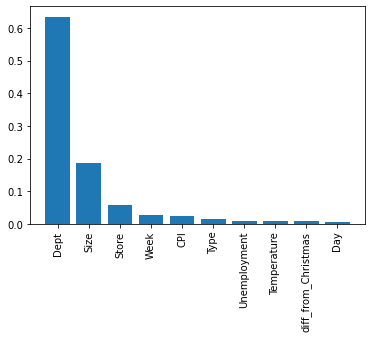

In [73]:
plt.bar(range(10),importance[indices])
plt.xticks(range(10),name)
plt.xticks(rotation='vertical')
plt.show()

In [74]:
final_data

Store  Dept                 Date  Weekly_Sales IsHoliday  Temperature  \
0           1     1  1265328000000000000      24924.50         0        42.31   
1           1     2  1265328000000000000      50605.27         0        42.31   
2           1     3  1265328000000000000      13740.12         0        42.31   
3           1     4  1265328000000000000      39954.04         0        42.31   
4           1     5  1265328000000000000      32229.38         0        42.31   
...       ...   ...                  ...           ...       ...          ...   
421565     45    93  1351209600000000000       2487.80         0        58.85   
421566     45    94  1351209600000000000       5203.31         0        58.85   
421567     45    95  1351209600000000000      56017.47         0        58.85   
421568     45    97  1351209600000000000       6817.48         0        58.85   
421569     45    98  1351209600000000000       1076.80         0        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  ...  Type    Size  \
0            2.572       0.00       0.00        0.0  ...     1  151315   
1            2.572       0.00       0.00        0.0  ...     1  151315   
2            2.572       0.00       0.00        0.0  ...     1  151315   
3            2.572       0.00       0.00        0.0  ...     1  151315   
4            2.572       0.00       0.00        0.0  ...     1  151315   
...            ...        ...        ...        ...  ...   ...     ...   
421565       3.882    4018.91      58.08      100.0  ...     2  118221   
421566       3.882    4018.91      58.08      100.0  ...     2  118221   
421567       3.882    4018.91      58.08      100.0  ...     2  118221   
421568       3.882    4018.91      58.08      100.0  ...     2  118221   
421569       3.882    4018.91      58.08      100.0  ...     2  118221   

           Temp_bins  Year Month  Week  Day  diff_from_Christmas  \
0       9.640847e+08  2010     2     5    5                  329   
1       9.640847e+08  2010     2     5    5                  329   
2       9.640847e+08  2010     2     5    5                  329   
3       9.640847e+08  2010     2     5    5                  329   
4       9.640847e+08  2010     2     5    5                  329   
...              ...   ...   ...   ...  ...                  ...   
421565  1.122390e+09  2012    10    43   26                    0   
421566  1.122390e+09  2012    10    43   26                    0   
421567  1.122390e+09  2012    10    43   26                    0   
421568  1.122390e+09  2012    10    43   26                    0   
421569  1.122390e+09  2012    10    43   26                    0   

        days_from_thanksgiving  IsHoliday_bins  
0                          294               0  
1                          294               0  
2                          294               0  
3                          294               0  
4                          294               0  
...                        ...             ...  
421565                       0               0  
421566                       0               0  
421567                       0               0  
421568                       0               0  
421569                       0               0  

[420285 rows x 24 columns]

In [75]:
regressors = ['Store','Dept','CPI','Size','Week','Type','Unemployment','Temperature','Day']
pred = ['Date','Weekly_Sales']
final = final_data.reindex(columns=['Date','Store','Dept','CPI','Size','Week','Type','Unemployment','Temperature','Day','Weekly_Sales'])

In [76]:
temp_test = pd.merge(test[((test['Store']==1) & (test['Dept']==1))],features, on=['Date','Store'])

In [77]:
len(final[(final['Store'] == 1) & (final['Dept'] == 1)])

143

In [78]:
pd.merge(temp_test, stores, on=['Store'])

Store  Dept        Date  IsHoliday_x  Temperature  Fuel_Price  MarkDown1  \
0       1     1  2012-11-02        False        55.32       3.386    6766.44   
1       1     1  2012-11-09        False        61.24       3.314   11421.32   
2       1     1  2012-11-16        False        52.92       3.252    9696.28   
3       1     1  2012-11-23         True        56.23       3.211     883.59   
4       1     1  2012-11-30        False        52.34       3.207    2460.03   
5       1     1  2012-12-07        False        64.12       3.198    6343.16   
6       1     1  2012-12-14        False        48.89       3.168    3504.83   
7       1     1  2012-12-21        False        56.02       3.098    8231.71   
8       1     1  2012-12-28         True        44.79       3.108   12659.55   
9       1     1  2013-01-04        False        41.73       3.161    1214.08   
10      1     1  2013-01-11        False        50.32       3.243    6520.24   
11      1     1  2013-01-18        False        42.92       3.237    3772.69   
12      1     1  2013-01-25        False        53.37       3.227     965.89   
13      1     1  2013-02-01        False        56.46       3.244    9290.91   
14      1     1  2013-02-08         True        56.67       3.417   32355.16   
15      1     1  2013-02-15        False        49.66       3.475   72937.29   
16      1     1  2013-02-22        False        50.25       3.597   20107.75   
17      1     1  2013-03-01        False        48.01       3.711   10610.74   
18      1     1  2013-03-08        False        50.81       3.658    5000.58   
19      1     1  2013-03-15        False        55.33       3.622    3808.13   
20      1     1  2013-03-22        False        63.42       3.611   12553.98   
21      1     1  2013-03-29        False        51.00       3.606   13067.46   
22      1     1  2013-04-05        False        58.59       3.583   12872.34   
23      1     1  2013-04-12        False        62.72       3.529    3672.43   
24      1     1  2013-04-19        False        67.10       3.451    3530.36   
25      1     1  2013-04-26        False        59.23       3.417    2387.72   
26      1     1  2013-05-03        False        66.66       3.386    2298.63   
27      1     1  2013-05-10        False        63.90       3.392    4624.61   
28      1     1  2013-05-17        False        69.53       3.454   16170.50   
29      1     1  2013-05-24        False        77.19       3.494    7959.89   
30      1     1  2013-05-31        False        78.02       3.466    2369.77   
31      1     1  2013-06-07        False        76.44       3.439    3514.75   
32      1     1  2013-06-14        False        79.86       3.431   12592.32   
33      1     1  2013-06-21        False        81.35       3.479    8104.02   
34      1     1  2013-06-28        False        83.94       3.495    4205.98   
35      1     1  2013-07-05        False        79.85       3.422    7649.99   
36      1     1  2013-07-12        False        83.12       3.400    6089.94   
37      1     1  2013-07-19        False        79.26       3.556    3117.04   
38      1     1  2013-07-26        False        81.54       3.620     332.17   

    MarkDown2  MarkDown3  MarkDown4  MarkDown5  IsHoliday_y         CPI  \
0     5147.70      50.82    3639.90    2737.42        False  223.536754   
1     3370.89      40.28    4646.79    6154.16        False  223.580287   
2      292.10     103.78    1133.15    6612.69        False  223.597660   
3        4.17   74910.32     209.91     303.32         True  223.599366   
4         NaN    3838.35     150.57    6966.34        False  223.621580   
5         NaN     270.00    2928.90   10147.90        False  223.694897   
6         NaN      73.26    1636.80    2779.60        False  223.816069   
7         NaN     274.00     358.15    2834.02        False  223.950568   
8    37101.13     174.78      74.46    1208.86         True  224.060358   
9    25366.33      15.01      72.36    3940.02       

In [80]:
fb_train = final[(final['Store'] == 1) & (final['Dept'] == 1)][30:]

In [81]:
fb_val = final[(final['Store'] == 1) & (final['Dept'] == 1)][0:30]
y_actual = fb_val['Weekly_Sales']
fb_val.drop(columns=['Weekly_Sales'], inplace=True)
fb_val

Date  Store  Dept         CPI    Size  Week Type  \
0     1265328000000000000      1     1  211.096358  151315     5    1   
73    1265932800000000000      1     1  211.242170  151315     6    1   
145   1266537600000000000      1     1  211.289143  151315     7    1   
218   1267142400000000000      1     1  211.319643  151315     8    1   
290   1267747200000000000      1     1  211.350143  151315     9    1   
363   1268352000000000000      1     1  211.380643  151315    10    1   
436   1268956800000000000      1     1  211.215635  151315    11    1   
508   1269561600000000000      1     1  211.018042  151315    12    1   
580   1270166400000000000      1     1  210.820450  151315    13    1   
652   1270771200000000000      1     1  210.622857  151315    14    1   
725   1271376000000000000      1     1  210.488700  151315    15    1   
798   1271980800000000000      1     1  210.439123  151315    16    1   
870   1272585600000000000      1     1  210.389546  151315    17    1   
941   1273190400000000000      1     1  210.339968  151315    18    1   
1013  1273795200000000000      1     1  210.337426  151315    19    1   
1085  1274400000000000000      1     1  210.617093  151315    20    1   
1155  1275004800000000000      1     1  210.896761  151315    21    1   
1225  1275609600000000000      1     1  211.176428  151315    22    1   
1296  1276214400000000000      1     1  211.456095  151315    23    1   
1367  1276819200000000000      1     1  211.453772  151315    24    1   
1436  1277424000000000000      1     1  211.338653  151315    25    1   
1505  1278028800000000000      1     1  211.223533  151315    26    1   
1578  1278633600000000000      1     1  211.108414  151315    27    1   
1649  1279238400000000000      1     1  211.100385  151315    28    1   
1719  1279843200000000000      1     1  211.235144  151315    29    1   
1791  1280448000000000000      1     1  211.369903  151315    30    1   
1863  1281052800000000000      1     1  211.504662  151315    31    1   
1933  1281657600000000000      1     1  211.639421  151315    32    1   
2004  1282262400000000000      1     1  211.603363  151315    33    1   
2076  1282867200000000000      1     1  211.567306  151315    34    1   

      Unemployment  Temperature  Day  
0            8.106        42.31    5  
73           8.106        38.51   12  
145          8.106        39.93   19  
218          8.106        46.63   26  
290          8.106        46.50    5  
363          8.106        57.79   12  
436          8.106        54.58   19  
508          8.106        51.45   26  
580          7.808        62.27    2  
652          7.808        65.86    9  
725          7.808        66.32   16  
798          7.808        64.84   23  
870          7.808        67.41   30  
941          7.808        72.55    7  
1013         7.808        74.78   14  
1085         7.808        76.44   21  
1155         7.808        80.44   28  
1225         7.808        80.69    4  
1296         7.808        80.43   11  
1367         7.808        84.11   18  
1436         7.808        84.34   25  
1505         7.787        80.91    2  
1578         7.787        80.48    9  
1649         7.787        83.15   16  
1719         7.787        83.36   23  
1791         7.787        81.84   30  
1863         7.787        87.16    6  
1933         7.787        87.00   13  
2004         7.787        86.65   20  
2076         7.787        85.22   27

In [82]:
df = pd.DataFrame()
test=split(test)
features['Date'] = pd.to_datetime(features['Date'])
temp_test = pd.merge(test,features, on=['Date','Store'])
test_dates = pd.merge(temp_test,stores, on=['Store'])[['Date','Store','Dept','CPI','Week','Day','Size','Type','Unemployment','Temperature']]
test_dates = test_dates.rename(columns = {'Date': 'ds'})
test_dates.loc[(test_dates.Type=='A') ,'Type']= 1
test_dates.loc[(test_dates.Type=='B') ,'Type']= 2
test_dates.loc[(test_dates.Type=='C') ,'Type']= 3
final_test = test_dates[(test_dates['Store']==1) & (test_dates['Dept']==1)]
# if(len(test_dates[(test_dates['Store']==1) & (test_dates['Dept']==1)]) > 2):
model4=Prophet()
for regressor in regressors:
    model4.add_regressor(name = regressor, standardize = False)
#fb_final=final[((final['Store']==1) & (final['Dept']==1))][['Date','Weekly_Sales','Store','Dept','CPI','Size','Week','Type','Unemployment','Temperature','Day']]
tserie = fb_train.rename(columns = {'Date': 'ds', 'Weekly_Sales': 'y'}, inplace = False)
tserie =tserie.sort_values(by=['ds'])
tserie['ds'] = pd.to_datetime(tserie['ds'])
fb_val = fb_val.rename(columns={'Date':'ds'})
fb_val['ds'] = pd.to_datetime(fb_val['ds'])
model4.fit(tserie)
prediction=model4.predict(fb_val)
df=df.append(prediction)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.9135
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -3.9135             0        264097       1e-12       0.001       32   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -148.896
Iteration  1. Log joint probability =    31.2932. Improved by 180.189.
Iteration  2. Log joint probability =    167.375. Improved by 136.082.
Iteration  3. Log joint probability =    206.331. Improved by 38.9558.
Iteration  4. Log joint probability =    206.949. Improved by 0.617537.
Iteration  5. Log joint probability =    207.073. Improved by 0.124321.
Iteration  6. Log joint probability =    207.085. Improved by 0.0120929.
Iteration  7. Log joint probability =    207.098. Improved by 0.0127436.
Iteration  8. Log joint probability =    207.103. Improved by 0.00498919.
Iteration  9. Log joint probability =    

In [83]:
df

ds        trend    yhat_lower    yhat_upper  trend_lower  \
0  2010-02-05  8753.116757  29129.489615  43389.835805  8753.116757   
1  2010-02-12  8633.316712  34457.692300  48544.438031  8633.316712   
2  2010-02-19  8513.516667  32240.669082  46546.715717  8513.516667   
3  2010-02-26  8393.716623  25657.689808  39928.081919  8393.716623   
4  2010-03-05  8273.916578  16743.951511  31125.125975  8273.916578   
5  2010-03-12  8154.116533  13526.023618  27510.345264  8154.116533   
6  2010-03-19  8034.316489  14811.514582  29829.359654  8034.316489   
7  2010-03-26  7914.516444  21563.527508  35656.481147  7914.516444   
8  2010-04-02  7794.716399  26443.813311  41399.553284  7794.716399   
9  2010-04-09  7674.916355  29468.833145  43618.272453  7674.916355   
10 2010-04-16  7555.116310  28394.996851  43275.722583  7555.116310   
11 2010-04-23  7435.316265  25506.169722  40069.470327  7435.316265   
12 2010-04-30  7315.516220  20865.267398  35184.516655  7315.516220   
13 2010-05-07  7195.716176  14251.912955  28885.756997  7195.716176   
14 2010-05-14  7075.916131  10596.318628  25767.800659  7075.916131   
15 2010-05-21  6956.116086   9977.706058  24518.685492  6956.116086   
16 2010-05-28  6836.316042  11062.045779  25534.925647  6836.316042   
17 2010-06-04  6716.515997  11909.744887  26022.924900  6716.515997   
18 2010-06-11  6596.715952  12593.532649  27338.487903  6596.715952   
19 2010-06-18  6476.915907  12318.818422  26403.836201  6476.915907   
20 2010-06-25  6357.115863  11144.975766  25420.463909  6357.115863   
21 2010-07-02  6237.315818  11000.876454  24742.758417  6237.315818   
22 2010-07-09  6117.515773  11743.399882  25727.285100  6117.515773   
23 2010-07-16  5997.715729  11971.463870  26077.587961  5997.715729   
24 2010-07-23  5877.915684  11954.977335  26082.874070  5877.915684   
25 2010-07-30  5758.115639  11149.305168  25210.434138  5758.115639   
26 2010-08-06  5638.315595  10253.694183  24445.793371  5638.315595   
27 2010-08-13  5518.515550  11161.740120  25010.313908  5518.515550   
28 2010-08-20  5398.715505  11348.363749  25639.221648  5398.715505   
29 2010-08-27  5278.915460  11458.761834  25746.637231  5278.915460   

    trend_upper            CPI      CPI_lower      CPI_upper         Day  ...  \
0   8753.116757  195125.731010  195125.731010  195125.731010  149.509141  ...   
1   8633.316712  195260.511142  195260.511142  195260.511142  358.821937  ...   
2   8513.516667  195303.930462  195303.930462  195303.930462  568.134734  ...   
3   8393.716623  195332.122966  195332.122966  195332.122966  777.447531  ...   
4   8273.916578  195360.315469  195360.315469  195360.315469  149.509141  ...   
5   8154.116533  195388.507973  195388.507973  195388.507973  358.821937  ...   
6   8034.316489  195235.983849  195235.983849  195235.983849  568.134734  ...   
7   7914.516444  195053.340241  195053.340241  195053.340241  777.447531  ...   
8   7794.716399  194870.696725  194870.696725  194870.696725   59.803656  ...   
9   7674.916355  194688.053209  194688.053209  194688.053209  269.116453  ...   
10  7555.116310  194564.045571  194564.045571  194564.045571  478.429250  ...   
11  7435.316265  194518.219166  194518.219166  194518.219166  687.742047  ...   
12  7315.516220  194472.392760  194472.392760  194472.392760  897.054843  ...   
13  7195.716176  194426.566354  194426.566354  194426.566354  209.312797  ...   
14  7075.916131  194424.216393  194424.216393  194424.216393  418.625594  ...   
15  6956.116086  194682.725288  194682.725288  194682.725288  627.938390  ...   
16  6836.316042  194941.234091  194941.234091  194941.234091  837.251187  ...   
17  6716.515997  195199.742894  195199.742894  195199.742894  119.607312  ...   
18  6596.715952  195458.251789  195458.251789  195458.251789  328.920109  ...   
19  6476.915907  195456.104352  195456.104352  195456.104352  538.232906  ...   
20  6357.115863  195349.694475  195349.694475  195349.694475  747.545703  ...   
21  6237.315818  195243.284

In [84]:
import numpy as np
err = np.mean(((y_actual - df.yhat)/y_actual)**2)
err

0.22231181191843402

In [85]:
rmse = np.mean((y_actual- df.yhat)**2)**0.5
rmse

11751.8901710293

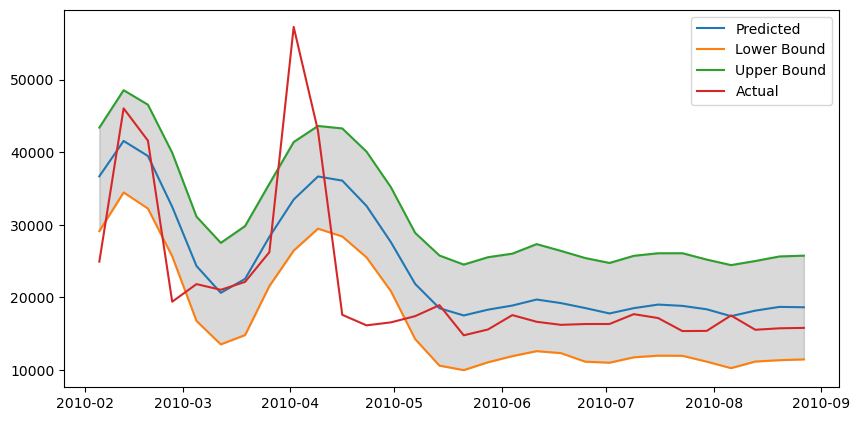

In [86]:
pred_df = df[['ds','yhat','yhat_lower','yhat_upper']]
fig, axes = plt.subplots(1, 1, figsize=(10,5), dpi=100, sharex=True)
plt.plot(df.ds, df.yhat, label='Predicted')
plt.plot(df.ds, df.yhat_lower, label='Lower Bound')
plt.plot(df.ds, df.yhat_upper, label='Upper Bound')
plt.fill_between(df.ds, 
                  df.yhat_lower, 
                  df.yhat_upper, 
                 color='k', alpha=.15)
plt.plot(df.ds, y_actual, label='Actual')
plt.legend()

In [87]:
df_final = pd.DataFrame()
prediction_final=model4.predict(final_test)
df_final=df_final.append(prediction_final)

In [88]:
df_final

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2012-11-02  -8378.289624  24851.616355  39407.359001  -8378.289624   
1  2012-11-09  -8498.089669  19218.178136  33607.008282  -8498.089672   
2  2012-11-16  -8617.889713  11669.262096  25755.442800  -8617.889721   
3  2012-11-23  -8737.689758   8464.759324  22646.233011  -8737.689772   
4  2012-11-30  -8857.489802  14316.333614  29085.500319  -8857.489824   
5  2012-12-07  -8977.289847  25658.808732  39425.665690  -8977.289877   
6  2012-12-14  -9097.089892  36439.690558  50549.311110  -9097.089931   
7  2012-12-21  -9216.889936  35506.987080  50122.831244  -9216.889987   
8  2012-12-28  -9336.689981  25488.171790  39401.010767  -9336.690042   
9  2013-01-04  -9456.490025  17634.136263  31984.515745  -9456.490097   
10 2013-01-11  -9576.290070   5849.004765  20255.469328  -9576.290152   
11 2013-01-18  -9696.090115   4001.285493  18040.098534  -9696.090210   
12 2013-01-25  -9815.890159  10068.287565  24000.613515  -9815.890266   
13 2013-02-01  -9935.690204  19200.757484  33304.676667  -9935.690325   
14 2013-02-08 -10055.490248  27211.005841  41456.032430 -10055.490383   
15 2013-02-15 -10175.290293  28516.357740  42600.869923 -10175.290444   
16 2013-02-22 -10295.090338  24258.199843  38297.092972 -10295.090502   
17 2013-03-01 -10414.890382  16082.190901  30137.902002 -10414.890566   
18 2013-03-08 -10534.690427  10023.959278  23479.628173 -10534.690625   
19 2013-03-15 -10654.490471   8466.287676  22745.366750 -10654.490683   
20 2013-03-22 -10774.290516  12544.147825  26986.276754 -10774.290750   
21 2013-03-29 -10894.090561  19597.741682  33987.329409 -10894.090813   
22 2013-04-05 -11013.890605  23608.548408  38930.026260 -11013.890878   
23 2013-04-12 -11133.690650  25573.834287  39645.872899 -11133.690939   
24 2013-04-19 -11253.490694  23688.539350  37442.525744 -11253.491007   
25 2013-04-26 -11373.290739  19515.723335  33767.119708 -11373.291075   
26 2013-05-03 -11493.090784  13245.059882  27336.218733 -11493.091135   
27 2013-05-10 -11612.890828   9011.952221  23293.068537 -11612.891200   
28 2013-05-17 -11732.690873   7017.854180  20838.649110 -11732.691265   
29 2013-05-24 -11852.490917   6430.740632  21122.593276 -11852.491330   
30 2013-05-31 -11972.290962   7904.261524  21812.374522 -11972.291390   
31 2013-06-07 -12092.091007   7612.345611  22304.077916 -12092.091453   
32 2013-06-14 -12211.891051   7874.274557  22171.470481 -12211.891525   
33 2013-06-21 -12331.691096   7055.737977  21629.375630 -12331.691595   
34 2013-06-28 -12451.491140   7224.666789  20784.799654 -12451.491665   
35 2013-07-05 -12571.291185   6446.933193  20515.276865 -12571.291737   
36 2013-07-12 -12691.091229   7284.276920  21243.484535 -12691.091807   
37 2013-07-19 -12810.891274   7095.132774  21817.301119 -12810.891885   
38 2013-07-26 -12930.691319   6721.313237  21030.179084 -12930.691958   

     trend_upper            CPI      CPI_lower      CPI_upper         Day  \
0   -8378.289624  206624.940561  206624.940561  206624.940561   59.803656   
1   -8498.089666  206665.179926  206665.179926  206665.179926  269.116453   
2   -8617.889706  206681.239316  206681.239316  206681.239316  478.429250   
3   -8737.689745  206682.815926  206682.815926  206682.815926  687.742047   
4   -8857.489781  206703.349604  206703.349604  206703.349604  897.054843   
5   -8977.289817  206771.119634  206771.119634  206771.119634  209.312797   
6   -9097.089853  206883.124350  206883.124350  206883.124350  418.625594   
7   -9216.889888  207007.447206  207007.447206  207007.447206  627.938390   
8   -9336.689923  207108.931066  207108.931066  207108.931066  837.251187   
9   -9456.489957  207171.888113  207171.888113  207171.888113  119.607312   
10  -9576.289988  207202.581620  207202.581620  207202.581620  328.920109   
11  -9696.090022  207217.794152  207217.794152  207217.794152  538.232906   
12  -9815.890053  207235.517780  207235.517780  207235.517780  747.545703   
13  -9935.69

In [89]:
test_dates[(test_dates['Store']==1) & (test_dates['Dept']==1)]

ds  Store  Dept         CPI  Week  Day    Size Type  \
0    2012-11-02      1     1  223.536754    44    2  151315    1   
71   2012-11-09      1     1  223.580287    45    9  151315    1   
142  2012-11-16      1     1  223.597660    46   16  151315    1   
213  2012-11-23      1     1  223.599366    47   23  151315    1   
285  2012-11-30      1     1  223.621580    48   30  151315    1   
358  2012-12-07      1     1  223.694897    49    7  151315    1   
431  2012-12-14      1     1  223.816069    50   14  151315    1   
503  2012-12-21      1     1  223.950568    51   21  151315    1   
576  2012-12-28      1     1  224.060358    52   28  151315    1   
648  2013-01-04      1     1  224.128468     1    4  151315    1   
719  2013-01-11      1     1  224.161673     2   11  151315    1   
789  2013-01-18      1     1  224.178131     3   18  151315    1   
861  2013-01-25      1     1  224.197305     4   25  151315    1   
933  2013-02-01      1     1  224.237715     5    1  151315    1   
1006 2013-02-08      1     1  224.314280     6    8  151315    1   
1078 2013-02-15      1     1  224.430000     7   15  151315    1   
1151 2013-02-22      1     1  224.569723     8   22  151315    1   
1223 2013-03-01      1     1  224.706644     9    1  151315    1   
1295 2013-03-08      1     1  224.819127    10    8  151315    1   
1365 2013-03-15      1     1  224.902940    11   15  151315    1   
1436 2013-03-22      1     1  224.968272    12   22  151315    1   
1507 2013-03-29      1     1  225.027085    13   29  151315    1   
1578 2013-04-05      1     1  225.084944    14    5  151315    1   
1649 2013-04-12      1     1  225.143303    15   12  151315    1   
1720 2013-04-19      1     1  225.205267    16   19  151315    1   
1791 2013-04-26      1     1  225.275957    17   26  151315    1   
1864 2013-05-03      1     1  225.298241    18    3  151315    1   
1934 2013-05-10      1     1  225.382958    19   10  151315    1   
2007 2013-05-17      1     1  225.473818    20   17  151315    1   
2079 2013-05-24      1     1  225.562324    21   24  151315    1   
2151 2013-05-31      1     1  225.636944    22   31  151315    1   
2222 2013-06-07      1     1  225.682523    23    7  151315    1   
2294 2013-06-14      1     1  225.684357    24   14  151315    1   
2364 2013-06-21      1     1  225.639254    25   21  151315    1   
2433 2013-06-28      1     1  225.564359    26   28  151315    1   
2502 2013-07-05      1     1  225.491370    27    5  151315    1   
2573 2013-07-12      1     1  225.447000    28   12  151315    1   
2643 2013-07-19      1     1  225.436780    29   19  151315    1   
2713 2013-07-26      1     1  225.447814    30   26  151315    1   

      Unemployment  Temperature  
0         6.677241        55.32  
71        6.670866        61.24  
142       6.660289        52.92  
213       6.658173        56.23  
285       6.670234        52.34  
358       6.686289        64.12  
431       6.683445        48.89  
503       6.642579        56.02  
576       6.567186        44.79  
648       6.487082        41.73  
719       6.438992        50.32  
789       6.437701        42.92  
861       6.464208        53.37  
933       6.484138        56.46  
1006      6.480062        56.67  
1078      6.465629        49.66  
1151      6.466842        50.25  
1223      6.490094        48.01  
1295      6.511236        50.81  
1365      6.497948        55.33  
1436      6.442322        63.42  
1507      6.370019        51.00  
1578      6.317626        58.59  
1649      6.302404        62.72  
1720      6.313618        67.10  
1791      6.329319        59.23  
1864      6.332488        66.66  
1934      6.337922        63.90  
2007      6.338980        69.53  
2079      6.340820        77.19  
2151      6.344148        78.02  
2222      6.349235        76.44  
2294      6.359232        79.86  
2364      6.375493        81.35  
2433      6.391502        83.94  
2502      6.396280        79.85  
2573      6.386070        83.12  


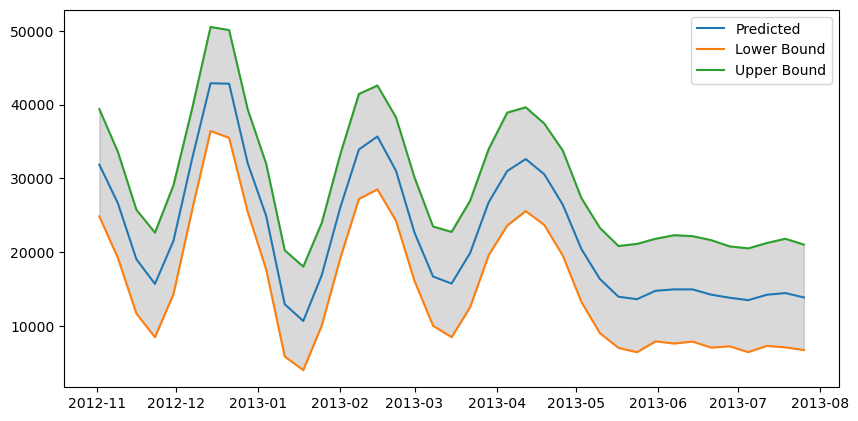

In [90]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), dpi=100, sharex=True)
plt.plot(df_final.ds, df_final.yhat, label='Predicted')
plt.plot(df_final.ds, df_final.yhat_lower, label='Lower Bound')
plt.plot(df_final.ds, df_final.yhat_upper, label='Upper Bound')
plt.fill_between(df_final.ds, 
                  df_final.yhat_lower, 
                  df_final.yhat_upper, 
                 color='k', alpha=.15)
plt.legend()

### Forecasting with SARIMA and SARIMAX

In [92]:
#Reading the training dataset
df_train = pd.read_csv('train.csv', parse_dates=['Date']).set_index(keys=['Store','Dept','Date'], drop=False)

In [93]:
#Removing the negative values in the sales
df_train = df_train[df_train.Weekly_Sales >= 0]
df_train.shape

(420285, 5)

In [97]:
#Reading other datasets
df_test = pd.read_csv('test.csv', parse_dates=['Date']).set_index(keys=['Store','Dept','Date'], drop=False)
df_stores = pd.read_csv('stores.csv').set_index(keys=['Store'], drop=False)
df_features = pd.read_csv('features.csv', parse_dates=['Date']).set_index(keys=['Store','Date'], drop=False)
df_train.index.names = ['Store_ind', 'Dept_ind', 'Date_ind']
df_test.index.names = ['Store_ind', 'Dept_ind', 'Date_ind']

In [98]:
#Data Cleaning
df_train['Weekofyear'] = df_train['Date'].dt.weekofyear
df_test['Weekofyear'] = df_test['Date'].dt.weekofyear
df_train['Month'] = df_train['Date'].dt.month
df_test['Month'] = df_test['Date'].dt.month
df_train['Year'] = df_train['Date'].dt.year
df_test['Year'] = df_test['Date'].dt.year
df_features['Temperature'] = (df_features['Temperature']-32.)/1.8 # to Celsius degree
df_features['Fuel_Price'] = df_features['Fuel_Price']/3.785411784 # to liters
df_train['pctchange_Weekly_Sales'] = df_train['Weekly_Sales'].pct_change().fillna(0.)

In [99]:
#Combining the dataframes
df_train_all = df_train.join(df_features[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                                          'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']],
                             on=['Store', 'Date'])
df_train_all = df_train_all.join(df_stores[['Type','Size']], on=['Store'])
df_test_all = df_test.join(df_features[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                                        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']],
                           on=['Store', 'Date'])
df_test_all = df_test_all.join(df_stores[['Type','Size']], on=['Store'])

In [100]:
#Handling Categorical Variables
from sklearn.preprocessing import LabelEncoder
list_dummies = ['IsHoliday', 'Type']
df_train_all['IsHoliday'] = pd.get_dummies(df_train_all['IsHoliday'],drop_first=True)
df_test_all['IsHoliday'] = pd.get_dummies(df_train_all['IsHoliday'],drop_first=True)
labelencoder = LabelEncoder()
df_train_all['Type'] = labelencoder.fit_transform(df_train_all['Type'])
df_test_all['Type'] = labelencoder.fit_transform(df_test_all['Type'])
#df_train_all['Type'] = pd.get_dummies(df_train_all['Type'],drop_first=True)
#df_test_all['Type'] = pd.get_dummies(df_train_all['Type'],drop_first=True)

list_markdown = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_train_all[list_markdown] = df_train_all[list_markdown].fillna(0.)
df_test_all[list_markdown] = df_test_all[list_markdown].fillna(0.)

In [101]:
#Lists of features, date components and Store Dept Combination
list_inpfeat = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Type', 'Size']
list_inpdate = ['Weekofyear', 'Month', 'Year']
list_store_dept = [(1,1),(2,2),(3,3),(4,4),(5,5)]

In [102]:
#Printing the dataset
df_train_all.head(10) 

Store  Dept       Date  Weekly_Sales  \
Store_ind Dept_ind Date_ind                                           
1         1        2010-02-05      1     1 2010-02-05      24924.50   
                   2010-02-12      1     1 2010-02-12      46039.49   
                   2010-02-19      1     1 2010-02-19      41595.55   
                   2010-02-26      1     1 2010-02-26      19403.54   
                   2010-03-05      1     1 2010-03-05      21827.90   
                   2010-03-12      1     1 2010-03-12      21043.39   
                   2010-03-19      1     1 2010-03-19      22136.64   
                   2010-03-26      1     1 2010-03-26      26229.21   
                   2010-04-02      1     1 2010-04-02      57258.43   
                   2010-04-09      1     1 2010-04-09      42960.91   

                               IsHoliday  Weekofyear  Month  Year  \
Store_ind Dept_ind Date_ind                                         
1         1        2010-02-05          0           5      2  2010   
                   2010-02-12          1           6      2  2010   
                   2010-02-19          0           7      2  2010   
                   2010-02-26          0           8      2  2010   
                   2010-03-05          0           9      3  2010   
                   2010-03-12          0          10      3  2010   
                   2010-03-19          0          11      3  2010   
                   2010-03-26          0          12      3  2010   
                   2010-04-02          0          13      4  2010   
                   2010-04-09          0          14      4  2010   

                               pctchange_Weekly_Sales  Temperature  \
Store_ind Dept_ind Date_ind                                          
1         1        2010-02-05                0.000000     5.727778   
                   2010-02-12                0.847158     3.616667   
                   2010-02-19               -0.096525     4.405556   
                   2010-02-26               -0.533519     8.127778   
                   2010-03-05                0.124944     8.055556   
                   2010-03-12               -0.035941    14.327778   
                   2010-03-19                0.051952    12.544444   
                   2010-03-26                0.184878    10.805556   
                   2010-04-02                1.183002    16.816667   
                   2010-04-09               -0.249702    18.811111   

                               Fuel_Price         CPI  Unemployment  \
Store_ind Dept_ind Date_ind                                           
1         1        2010-02-05    0.679451  211.096358         8.106   
                   2010-02-12    0.673110  211.242170         8.106   
                   2010-02-19    0.664129  211.289143         8.106   
                   2010-02-26    0.676545  211.319643         8.106   
                   2010-03-05    0.693452  211.350143         8.106   
                   2010-03-12    0.704547  211.380643         8.106   
                   2010-03-19    0.718548  211.215635         8.106   
                   2010-03-26    0.721718  211.018042         8.106   
                   2010-04-02    0.718284  210.820450         7.808   
                   2010-04-09    0.731757  210.622857         7.808   

                               MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
Store_ind Dept_ind Date_ind                                                 
1         1        2010-02-05        0.0        0.0        0.0        0.0   
                   2010-02-12        0.0        0.0        0.0        0.0   
                   2010-02-19        0.0        0.0        0.0        0.0   
                   2010-02-26        0.0        0.0        0.0        0.0   
                   2010-03-05        0.0        0.0        0.0        0.0   
                   2010-03-12        0.0        0.0        0.0        0.0   
                   2010-03-19        0.

In [103]:
#Extracting data for particular dates for training
df_train_all2 = df_train_all.loc[(slice(None), slice(None), slice('2010-02-05','2012-02-03')),:] #
df_valid_all = df_train_all.loc[(slice(None), slice(None), slice('2012-02-10','2015-02-05')),:]

In [104]:
#Basic Statistics
Nstore = df_train.index.max()[0] ; Ndept = df_train.index.max()[1]
df_stats = pd.concat([df_train.groupby(['Store','Dept']).median().Weekly_Sales,
                      df_train.groupby(['Store','Dept']).mean().Weekly_Sales,
                      df_train.groupby(['Store','Dept']).std().Weekly_Sales,
                      df_train.groupby(['Store','Dept']).max().Weekly_Sales, 
                      df_train.groupby(['Store','Dept']).min().Weekly_Sales],
                     axis=1)
df_stats.columns = ['Median', 'Mean', 'Std', 'Max', 'Min']
df_stats['Norm_std'] = df_stats['Std']/(df_stats['Mean']) #np.abs
df_stats['Norm_maxmin'] = (df_stats['Max']-df_stats['Min'])/df_stats['Median']
df_stats = df_stats.sort_values(by=['Norm_std'], axis=0, ascending=False)
df_stats.to_csv('summary_stores_stats.csv')
df_stats.head()

Median         Mean          Std       Max     Min  Norm_std  \
Store Dept                                                                 
35    59    217.27   876.256279  2935.169709  26132.28    0.02  3.349670   
31    99     10.05   218.742203   643.554673   4380.01    0.01  2.942069   
13    99     90.02   732.604651  2070.103641  12225.00    0.06  2.825676   
10    59    585.23  2006.511119  5481.527708  49196.79  162.79  2.731870   
18    59    333.18   992.127972  2707.311593  23979.03   66.71  2.728793   

            Norm_maxmin  
Store Dept               
35    59     120.275510  
31    99     435.820896  
13    99     135.802488  
10    59      83.785862  
18    59      71.769974

#### Stationarity: ADF tests on the original TS

In [105]:
#Checking Stationarity of the time series
def adf_test(df):
    if len(df.Weekly_Sales) > 10:
        result = adfuller(df.Weekly_Sales, autolag='AIC')
    else:
        result = [np.nan, np.nan, np.nan, np.nan, np.nan]
    return result[1]
df_stats['ADF_pvalue'] = df_train_all.groupby(['Store','Dept']).apply(adf_test)
df_stats.sort_values(['Store','Dept'], axis=0, ascending=True).head()

Median          Mean           Std       Max       Min  \
Store Dept                                                             
1     1     18535.48  22513.322937   9854.349032  57592.12  14537.37   
      2     45561.85  46102.090420   3440.673222  65615.36  35819.83   
      3     10366.85  13150.478042   8708.978853  51159.17   6165.73   
      4     36579.96  36964.154476   2930.698313  47893.23  32497.43   
      5     21183.42  24257.941119  11330.286495  85676.09  11570.27   

            Norm_std  Norm_maxmin    ADF_pvalue  
Store Dept                                       
1     1     0.437712     2.322829  1.101743e-01  
      2     0.074632     0.653958  4.334646e-07  
      3     0.662256     4.340126  1.912685e-04  
      4     0.079285     0.420881  2.614709e-04  
      5     0.467075     3.498293  4.176075e-02

#### As we can see the p value in the ADF test is greater than 0.05, hence the time series is Non Stationary

#### Seasonal Decomposition

In [106]:
#Checking for components in the time series
def plot_season(df, list_store_dept):
    plt.rcParams.update({'figure.figsize': (8,5)})
    plt.figure(figsize=[15,10])
    plt.subplots_adjust(wspace=0.33, hspace=0.5)
    for ist, storedept in enumerate(list_store_dept):
        result_add = seasonal_decompose(df.loc[storedept,'Weekly_Sales'], 
                                        model='additive', extrapolate_trend='freq', freq=52)
        plt.subplot(len(list_store_dept),4,ist*4+1) ; plt.xticks(rotation=30)
        plt.plot(df.loc[storedept,'Weekly_Sales'],label=storedept) ; plt.ylabel('Weekly Sales') ; plt.legend()
        plt.subplot(len(list_store_dept),4,ist*4+2) ; plt.xticks(rotation=30)
        plt.plot(result_add.trend,label=storedept) ; plt.ylabel('Trend') ; plt.legend()
        plt.subplot(len(list_store_dept),4,ist*4+3) ; plt.xticks(rotation=30)
        plt.plot(result_add.seasonal) ; plt.ylabel('Seasonal')
        plt.subplot(len(list_store_dept),4,ist*4+4) ; plt.xticks(rotation=30)
        plt.plot(result_add.resid) ; plt.ylabel('Residual')

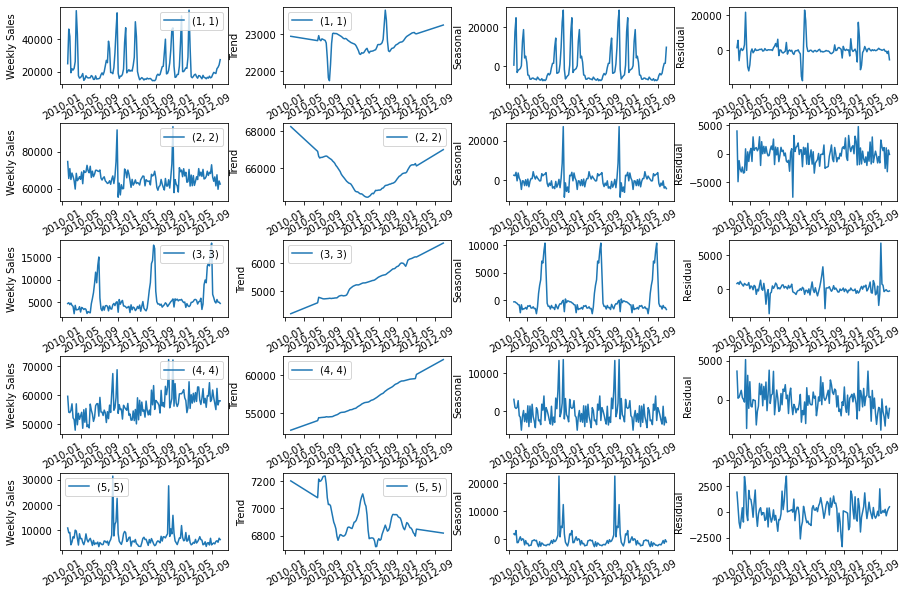

In [107]:
#Plotting the decomposition graph for all store department combination
plot_season(df_train_all, list_store_dept)

In [108]:
#Function to plot ACF and PACF
def plot_diff(df,list_diff,nlags):
    plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
    #
    df2 = df.Weekly_Sales.reset_index()#
    #
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for diff in list_diff:
        if diff > 0:
            df2 = df2.diff(diff)
    ax1.plot(df2.Weekly_Sales) ; ax1.set_title('Order Differencing '+str(list_diff))
    plot_acf(df2.Weekly_Sales.dropna(), ax=ax2,lags=nlags); ax2.set_xlim(0,nlags) ; ax2.set_ylim(-1,1) 
    plot_pacf(df2.Weekly_Sales.dropna(), ax=ax3,lags=nlags) ; ax3.set_xlim(0,nlags) ; ax3.set_ylim(-1,1) 

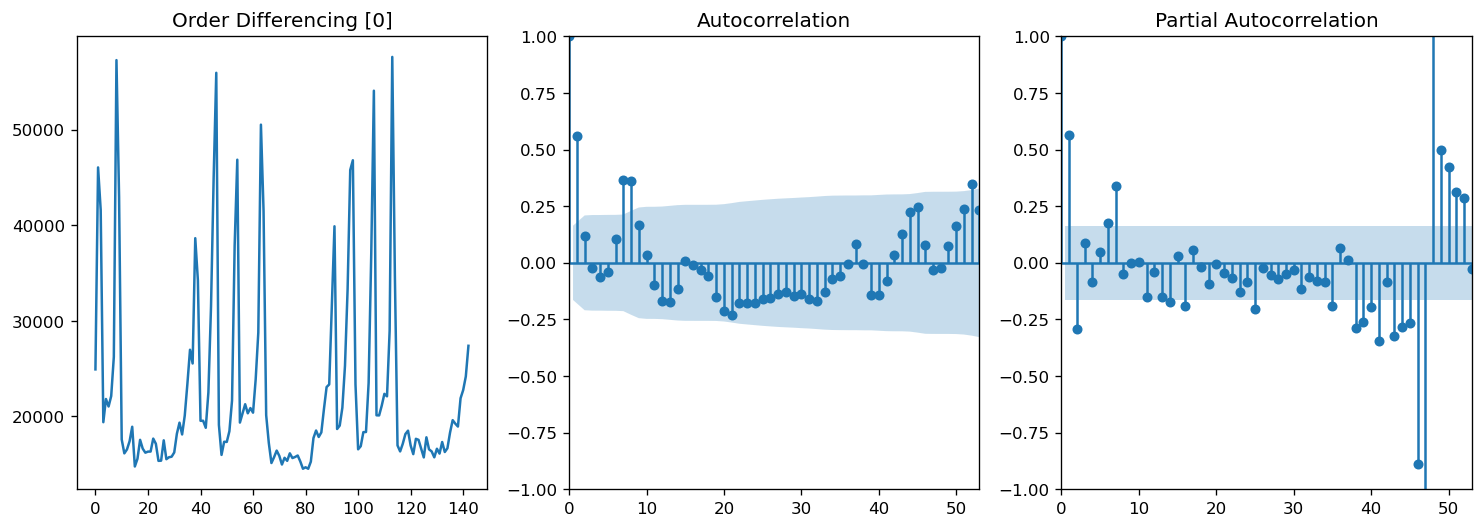

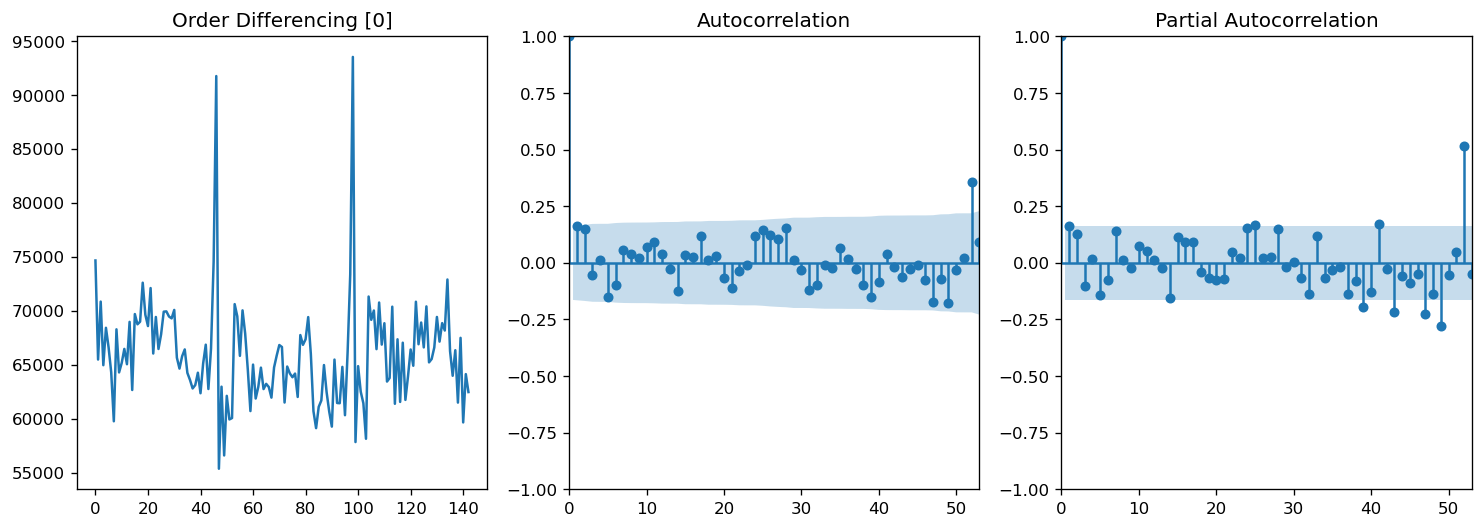

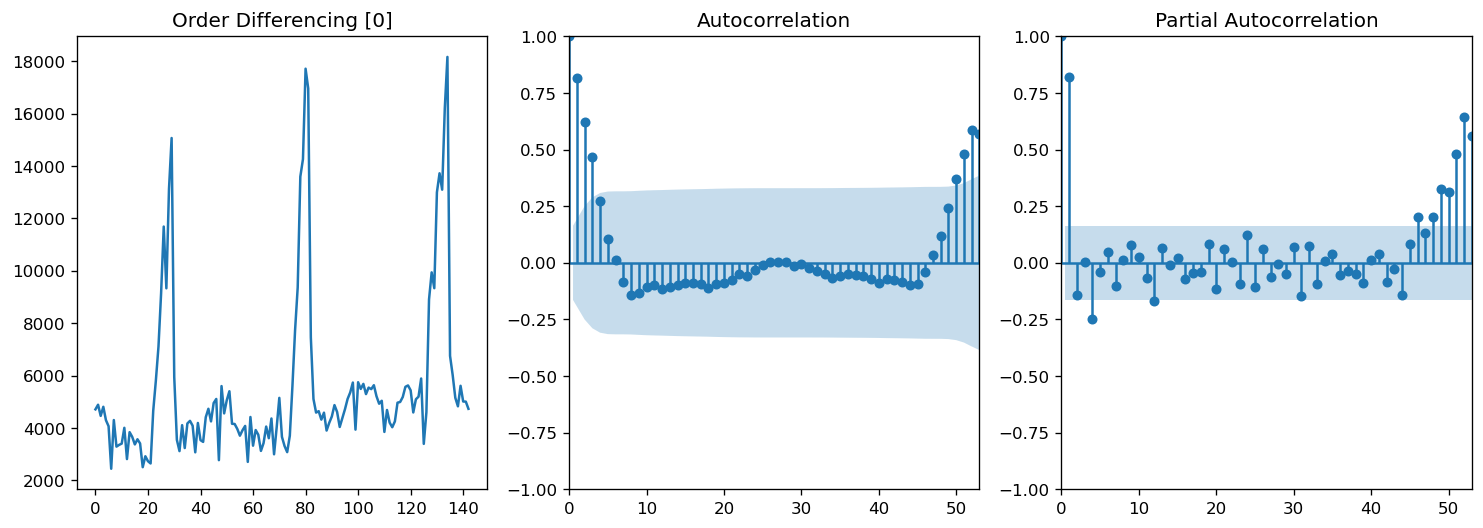

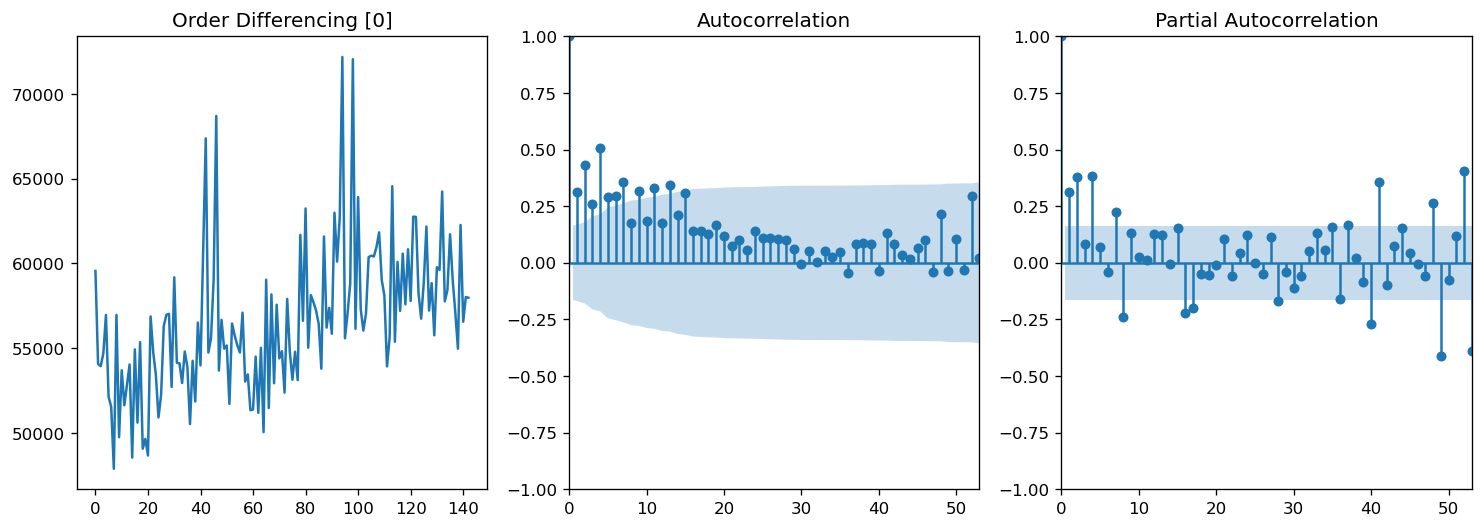

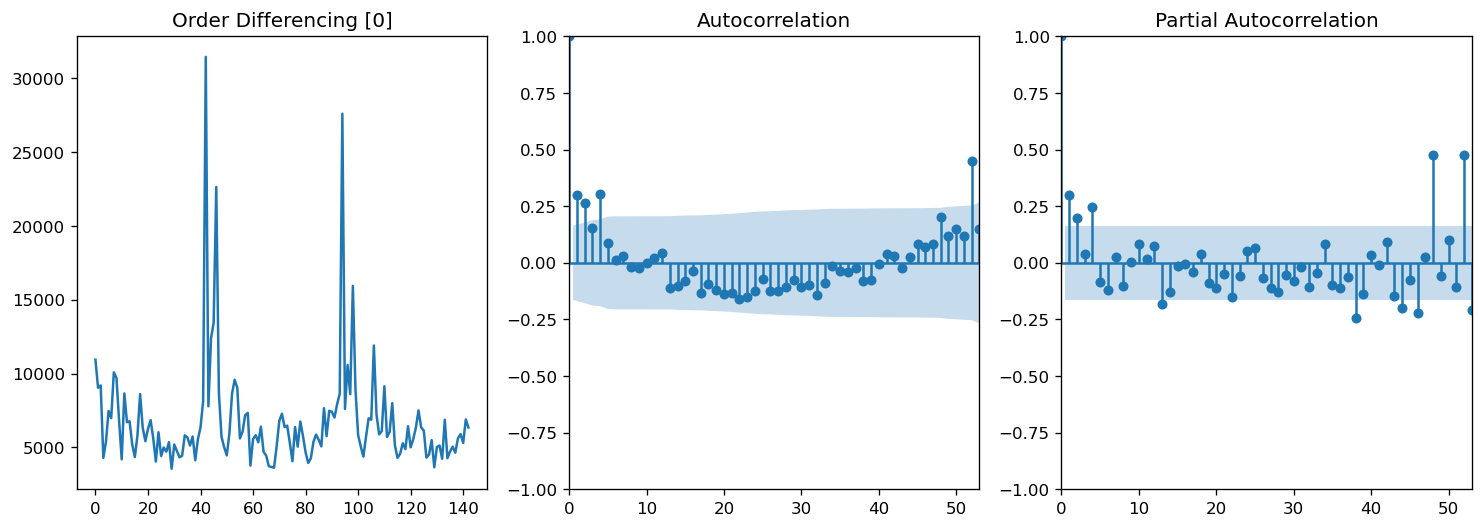

In [109]:
for i in list_store_dept:
    plot_diff(df_train_all.loc[i],[0],53)

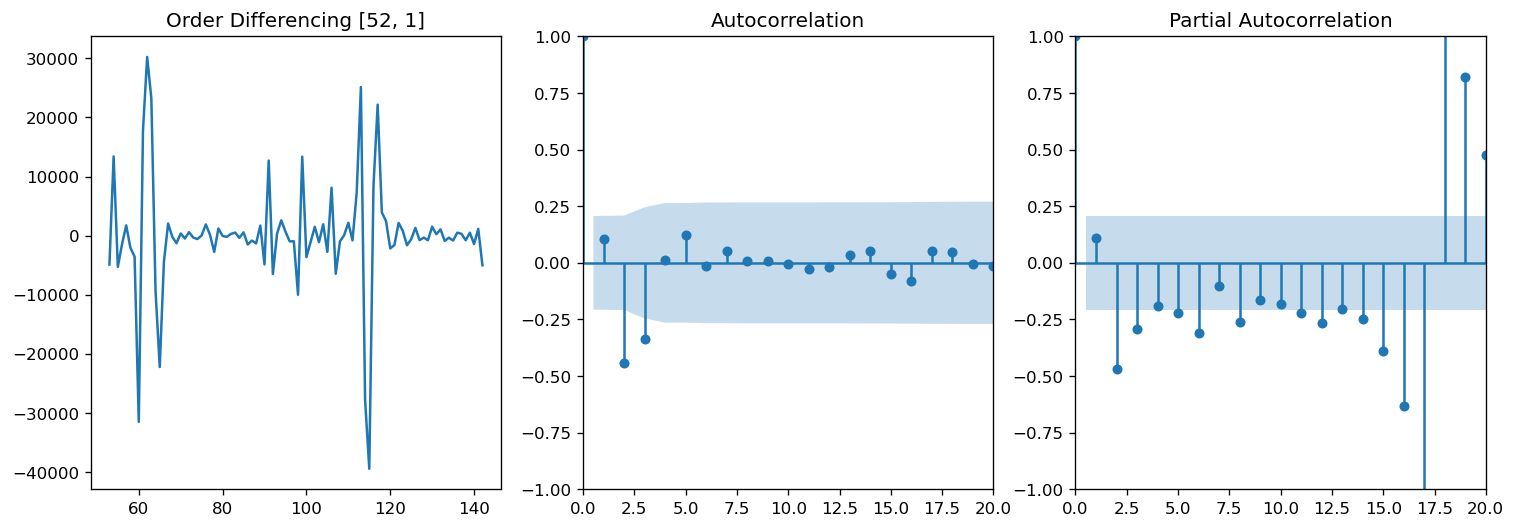

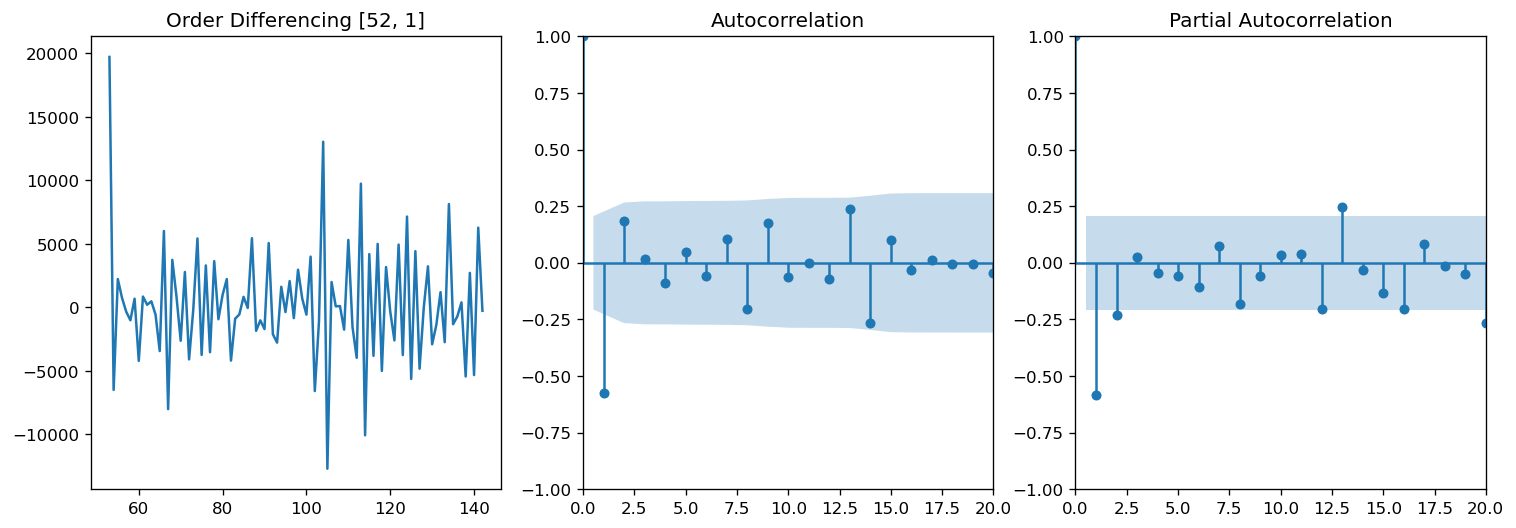

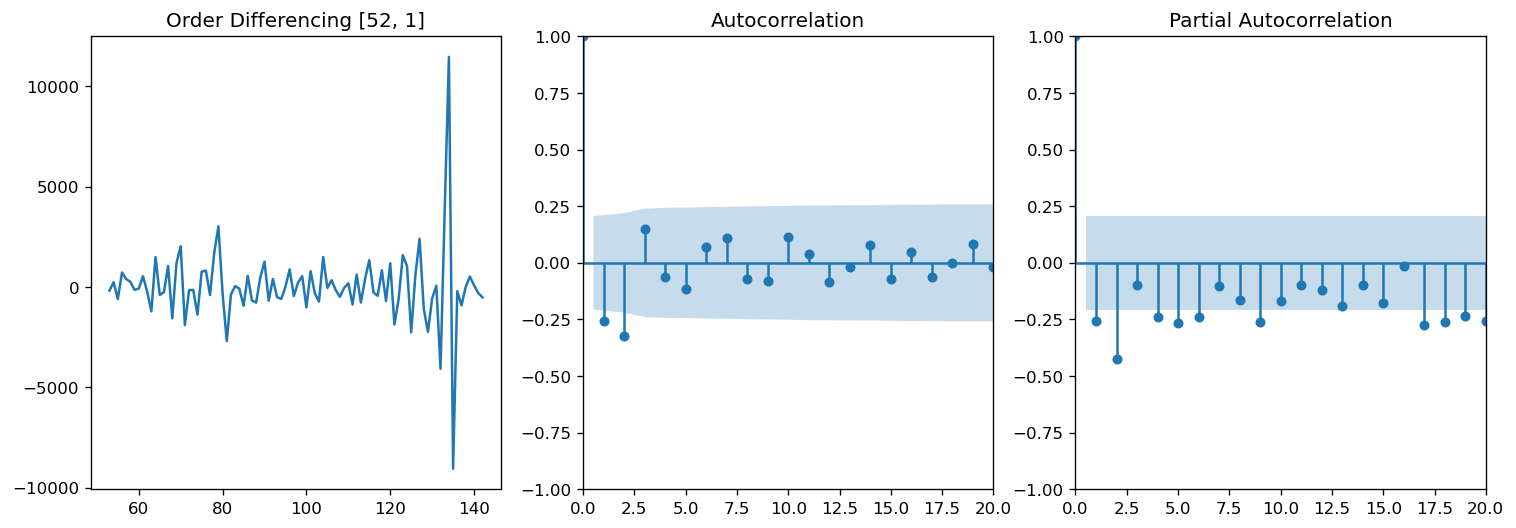

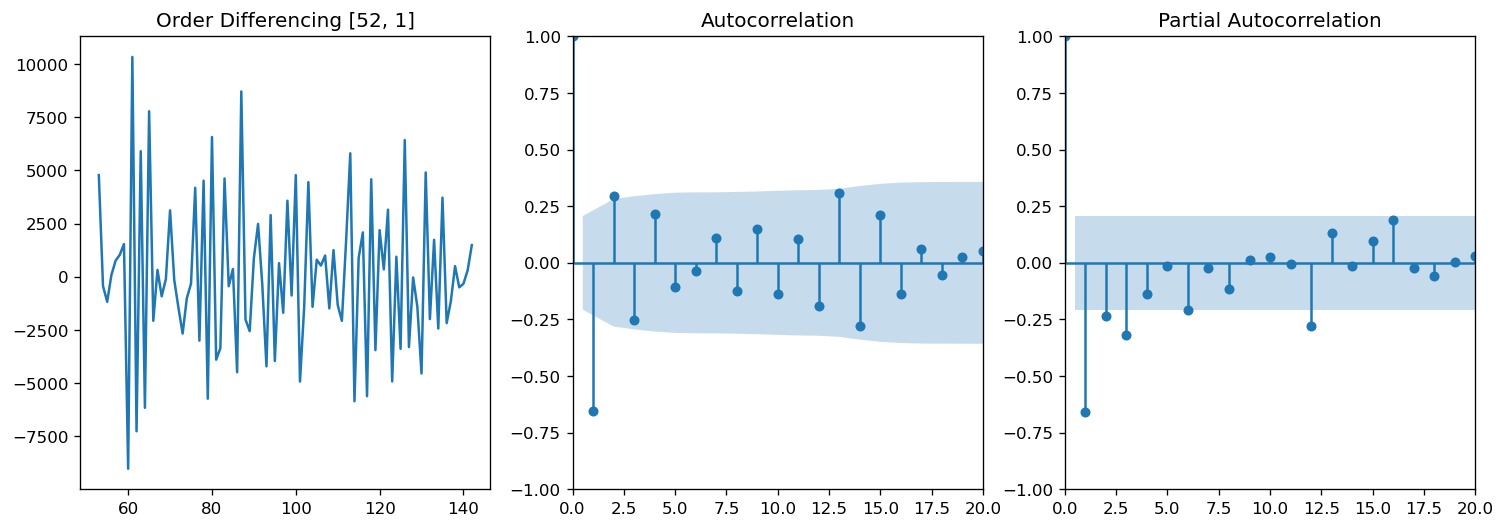

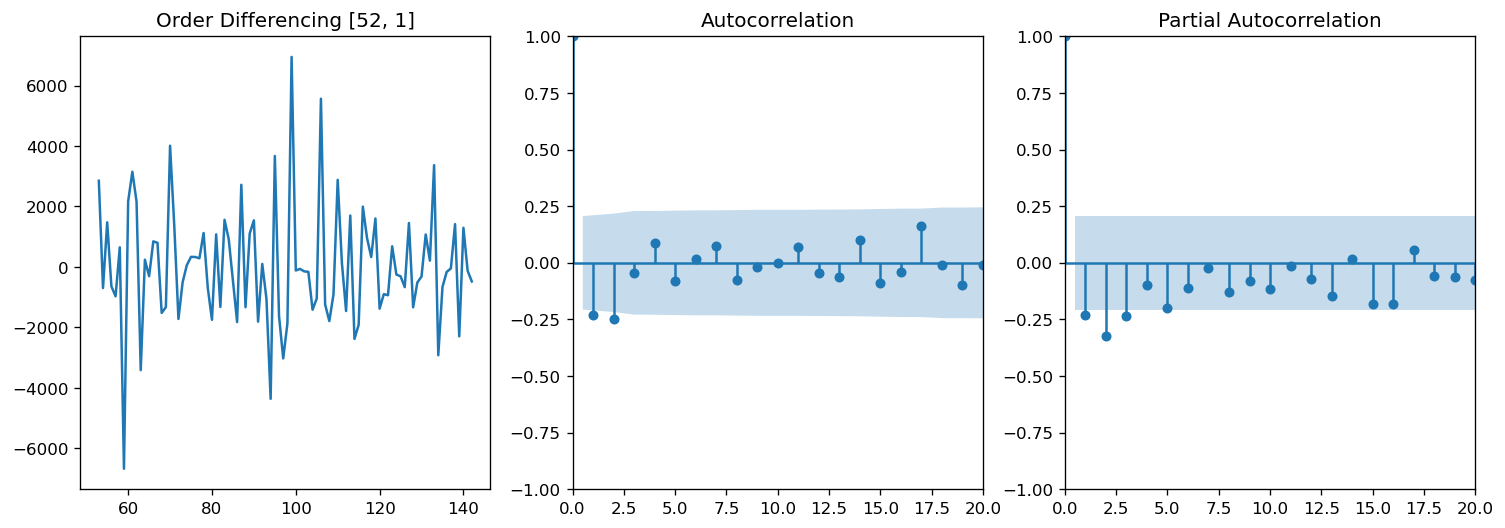

In [110]:
for i in list_store_dept:
    plot_diff(df_train_all.loc[i],[52,1],20)

#### Time series transformation

In [111]:
#Function to find rolling mean and standard deviation and plot them. Also, performs AD Fuller Test

def test_stationarity(ts,window):
 
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.figure(figsize=(8,3))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform ADF test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### Metrics and application with a super simple model

In [112]:
#Function to calculate the Accuracy Mertrices

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    me = np.mean(forecast - actual)             
    mae = np.mean(np.abs(forecast - actual))    
    mpe = np.mean((forecast - actual)/actual)   
    rmse = np.mean((forecast - actual)**2)**.5 
    corr = np.corrcoef(forecast, actual)[0,1]   
    mspe = np.mean(((actual - forecast)/actual)**2) 
    mse = np.square(np.subtract(actual,forecast)).mean()
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)            
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax, 'mspe' : mspe, 'mse':mse})

Let's start with a very simple model: the weekly sales averaged over the first two years. Two goals here:
(1) Get a first idea of the typical error for the chosen metrics
(2) Get a reference model to evaluate the improvement of more sophisticated models

### Simple Model

In [113]:
# Averaging the yearly evolution
mean_sale = df_train_all2.groupby(['Store','Dept','Weekofyear'])['Weekly_Sales'].mean()
df_valid_pred = df_valid_all[['Store', 'Dept', 'Weekofyear']].join(mean_sale, on=['Store', 'Dept', 'Weekofyear'])

In [114]:
df_valid_pred.head()

Store  Dept  Weekofyear  Weekly_Sales
Store_ind Dept_ind Date_ind                                         
1         1        2012-02-10      1     1           6     41963.330
                   2012-02-17      1     1           7     44220.710
                   2012-02-24      1     1           8     19383.685
                   2012-03-02      1     1           9     21077.755
                   2012-03-09      1     1          10     21161.895

#### Let's compare the predictions to the actual sales

In [115]:
# plot the predictions with actual data

def plot_predtarget(list_storedept, df_train, df_test, df_actual, target, plotname, dpi=100):
    color=cm.tab10(np.linspace(0,1,len(list_storedept)*2))
    plt.figure(0,figsize=(16,5), dpi=dpi)
    for ist, storedept in enumerate(list_storedept):
        dftrain = df_train.loc[storedept]
        dfpred = df_test.loc[storedept]
        dfactual = df_actual.loc[storedept]
        plt.plot(dftrain.index.to_pydatetime(),dftrain[target],color=color[ist],label=storedept)
        plt.plot(dfpred.index.to_pydatetime(),dfpred[target],color=color[ist],ls='--')
        plt.plot(dfactual.index.to_pydatetime(),dfactual[target],color=color[ist],ls='-')
    plt.gca().set(xlabel='Date', ylabel=target, title='Store ')
    plt.legend()
    plt.show()
    plt.close(0)

### SARIMA model

In [116]:
df_train_all2.loc[list_store_dept[0],'Weekly_Sales']

Date_ind
2010-02-05    24924.50
2010-02-12    46039.49
2010-02-19    41595.55
2010-02-26    19403.54
2010-03-05    21827.90
                ...   
2012-01-06    16567.69
2012-01-13    16894.40
2012-01-20    18365.10
2012-01-27    18378.16
2012-02-03    23510.49
Name: Weekly_Sales, Length: 105, dtype: float64

In [117]:
train = df_train_all2.loc[list_store_dept[0],'Weekly_Sales']
valid = df_valid_all.loc[list_store_dept[0],'Weekly_Sales']

In [118]:
#Perform a grid search by: varying (p,d,q) and (P,D,Q), using the AIC as information criterion

smodel = pm.auto_arima(train, 
                       start_p=1, start_q=1, start_d=1, # start p, q, d 
                       max_p=2, max_q=2,     # maximum p and q
                       max_d=2, d=None,        # let model determine 'd'
                       seasonal=True,        # Seasonality
                       m=52,                 # frequency of series
                       start_P=1, start_Q=1, # 
                       max_P=1, max_Q=1,     # maximum P and Q
                       D=1,                  # one "yearly" differentiation
                       test='adf',           # use adftest to find optimal 'd'
                       information_criterion='aic', # used to select best model
                       trace=True,          # print results whilst training
                       error_action='ignore',   # ignore orders that don't work
                       suppress_warnings=True, 
                       stepwise=True,       # apply intelligent order search
                      )


print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=1098.602, Time=5.23 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1116.417, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1098.990, Time=2.09 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1096.690, Time=1.84 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1115.016, Time=0.18 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1099.124, Time=0.28 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=1098.560, Time=4.18 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1096.624, Time=1.55 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1115.843, Time=1.08 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1096.638, Time=3.02 sec
 ARIMA(0,0,2)(1,1,0)[52] intercept   : AIC=1097.383, Time=2.05 sec
 ARIMA(1,0,2)(1,1,0)[52] intercept   : AIC=1097.086, Time=8.17 sec
 ARIMA(0,0,1)(1,1,0)[52]             : AIC=1094.288, Time=1.27 sec
 ARIMA(0,0,1)(0,1,0)[52]             : AIC=1097.173, Time=0.17 sec
 ARIMA(0,0,1)(1,1,1

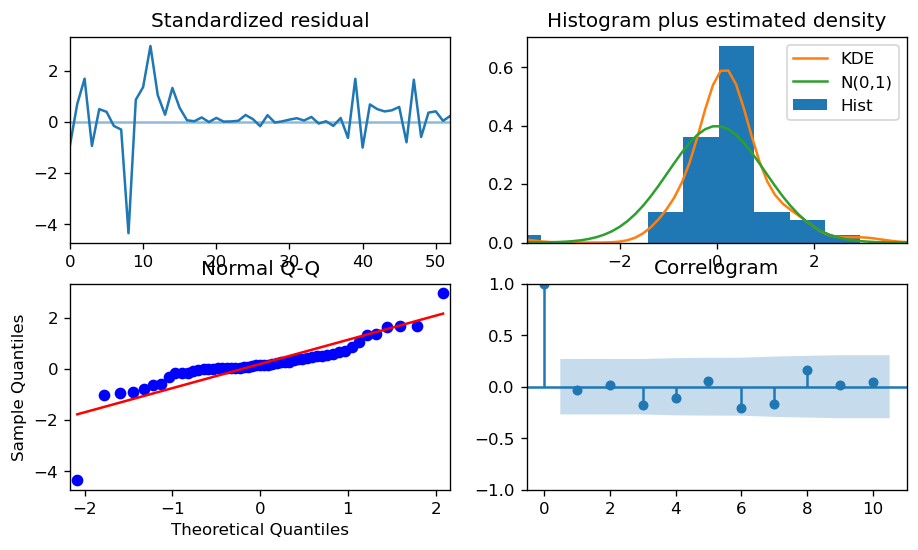

In [119]:
smodel.plot_diagnostics()
plt.show()

In [120]:
# Forecast
n_periods = len(valid.index) 
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
in_sample_preds, in_sample_confint = smodel.predict_in_sample(return_conf_int=True)
index_of_fc = valid.index #pd.date_range(valid.index[0], periods = Nteststeps, freq='7D')
#
# make forecast series
train_fc = pd.Series(in_sample_preds, index=train.index)
valid_fc = pd.Series(fitted, index=index_of_fc)
valid_fc_lower = pd.Series(confint[:, 0], index=index_of_fc)
valid_fc_upper = pd.Series(confint[:, 1], index=index_of_fc)

#### Let's perform the same process for other departments

In [127]:
#Perform a grid search by: varying (p,d,q) and (P,D,Q), using the AIC as information criterion


sarima_index = []
sarima_mape = []
sarima_train_fc = []
sarima_valid_fc = []
sarima_valid_fc_lower = []
sarima_valid_fc_upper = []
sarima_rmse = []

for storedept in list_store_dept: #[:2]:
    train = df_train_all2.loc[storedept,'Weekly_Sales'] ; valid = df_valid_all.loc[storedept,'Weekly_Sales']

    smodel = pm.auto_arima(train, 
                           start_p=1, start_q=1, 
                           max_p=2, max_q=2,     # maximum p and q
                           d=None,               # let model determine 'd'
                           seasonal=True,        # Seasonality
                           m=52,                 # frequency of series
                           start_P=1, start_Q=1, # 
                           max_P=1, max_Q=1,     # maximum P and Q
                           D=1,                  # one "yearly" differentiation
                           test='adf',           # use adftest to find optimal 'd'
                           information_criterion='aic', # used to select best model
                           trace=True,          # print results whilst training
                           error_action='ignore',   # ignore orders that don't work
                           suppress_warnings=True, 
                           stepwise=True,       # apply intelligent order search
                          )

    # get the forecast TS
    n_periods = len(valid.index)
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    in_sample_preds, in_sample_confint = smodel.predict_in_sample(return_conf_int=True)
    index_of_fc = valid.index

    # make forecast series
    train_fc = pd.Series(in_sample_preds, index=train.index)
    valid_fc = pd.Series(fitted, index=index_of_fc)
    valid_fc_lower = pd.Series(confint[:, 0], index=index_of_fc)
    valid_fc_upper = pd.Series(confint[:, 1], index=index_of_fc)

    # save the forecast 
    sarima_train_fc.append(train_fc) ; sarima_valid_fc.append(valid_fc)
    sarima_valid_fc_lower.append(valid_fc_lower) ; sarima_valid_fc_upper.append(valid_fc_upper)

    # evaluate the error
    sarima_mape.append(forecast_accuracy(valid_fc, valid)['mspe'])
    sarima_index.append(storedept)
    
    # evaluate the error
    sarima_rmse.append(forecast_accuracy(valid_fc, valid)['rmse'])
    #sarima_index.append(storedept)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=1098.602, Time=4.54 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1116.417, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1098.990, Time=1.83 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1096.690, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1115.016, Time=0.16 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1099.124, Time=0.22 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=1098.560, Time=5.51 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=1096.624, Time=1.88 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1115.843, Time=1.27 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1096.638, Time=3.51 sec
 ARIMA(0,0,2)(1,1,0)[52] intercept   : AIC=1097.383, Time=2.38 sec
 ARIMA(1,0,2)(1,1,0)[52] intercept   : AIC=1097.086, Time=8.02 sec
 ARIMA(0,0,1)(1,1,0)[52]             : AIC=1094.288, Time=1.30 sec
 ARIMA(0,0,1)(0,1,0)[52]             : AIC=1097.173, Time=0.20 sec
 ARIMA(0,0,1)(1,1,1

In [129]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  105
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 52)   Log Likelihood                -453.615
Date:                              Sun, 27 Mar 2022   AIC                            915.229
Time:                                      23:34:49   BIC                            923.034
Sample:                                           0   HQIC                           918.222
                                              - 105                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3713      0.168     -2.208      0.027      -0.701      -0.042
ma.L2         -0.2749      0.173     -1.592      0.111      -0.613       0.064
ma.S.L52      -0.3985      0.080     -4.950      0.000      -0.556      -0.241
sigma2      2.068e+06   2.99e+05      6.909      0.000    1.48e+06    2.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                38.44
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.17
Prob(H) (two-sided):                  0.77   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
# Compare predicted and actual test TS
def plot_forecast(stdep, train, trainfc, valid, validfc, validfclower, validfcupper, plottitle):
    fig, axes = plt.subplots(1, 1, figsize=(10,3), dpi=100, sharex=True)
    plt.plot(train, label='Training set')
    plt.plot(validfc, color='salmon', label='Forecast')
    try:
        plt.fill_between(validfclower.index, 
                         validfclower, 
                         validfcupper, 
                         color='b', alpha=.15)
    except:
        pass
    plt.plot(valid, color = 'green', label='Validation set')
    plt.legend()
    plt.title(plottitle+" - Forecast on validation set of "+str(stdep))
    plt.show()

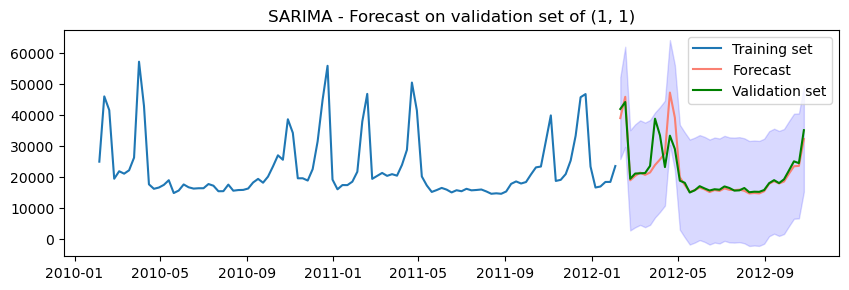

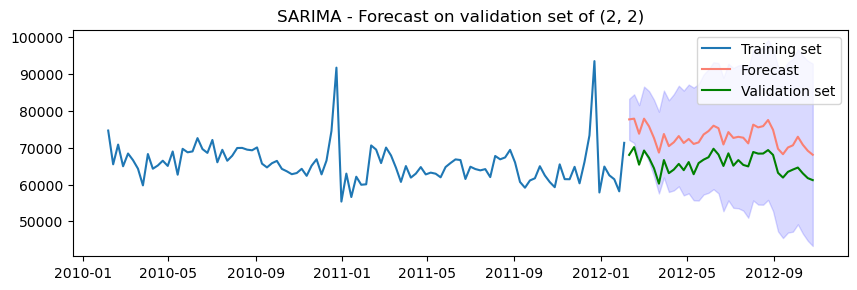

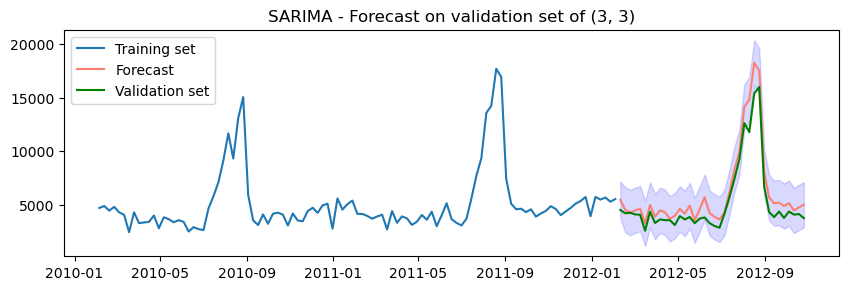

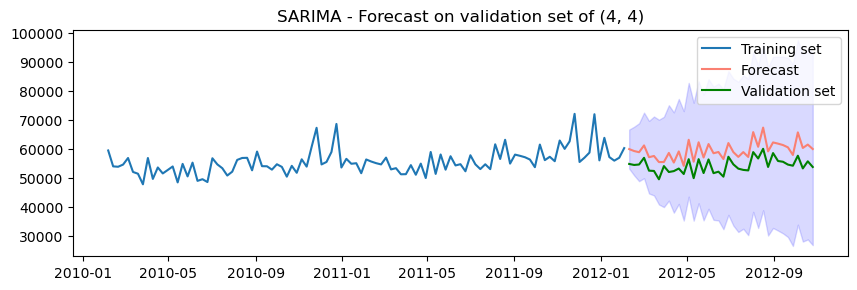

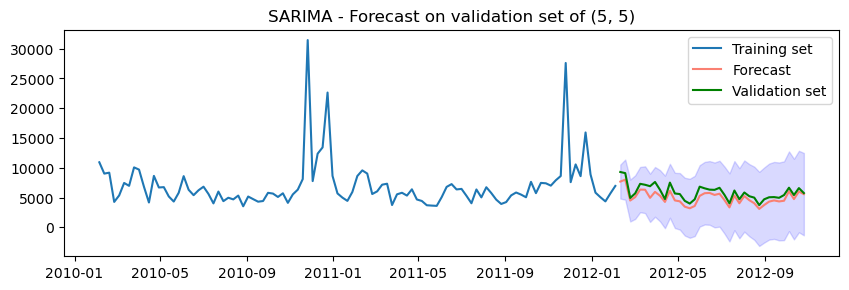

In [131]:
for isd, storedept in enumerate(list_store_dept):
    train = df_train_all2.loc[storedept,'Weekly_Sales'] ; valid = df_valid_pred.loc[storedept,'Weekly_Sales']
    train_fc = sarima_train_fc[isd]
    valid_fc = sarima_valid_fc[isd]
    valid_fc_lower = sarima_valid_fc_lower[isd]
    valid_fc_upper = sarima_valid_fc_upper[isd]
    plot_forecast(storedept, train, train_fc, valid, valid_fc, valid_fc_lower, valid_fc_upper, 'SARIMA')

In [132]:
df_mspe = pd.DataFrame({'MSPE_SARIMA' : sarima_mape}, index = sarima_index)
df_mspe.head()

MSPE_SARIMA
(1, 1)     0.151474
(2, 2)     0.011775
(3, 3)     0.034360
(4, 4)     0.001826
(5, 5)     0.046420

In [133]:
df_rmse = pd.DataFrame({'RMSE_SARIMA' : sarima_rmse}, index = sarima_index)
df_rmse.head()

RMSE_SARIMA
(1, 1)  8411.371973
(2, 2)  7061.857969
(3, 3)  2080.890442
(4, 4)  2558.878309
(5, 5)  1475.127115

### SARIMA with additional variables (SARIMAX)

In [134]:
#Perform a grid search by: varying (p,d,q) and (P,D,Q), using the AIC as information criterion
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

sarimax_index = []
sarimax_mspe = [] 
sarimax_train_fc = [] 
sarimax_valid_fc = []
sarimax_rmse = []
sarimax_valid_fc_lower = [] 
sarimax_valid_fc_upper = []

for storedept in list_store_dept:
    train = df_train_all2.loc[storedept,'Weekly_Sales'] ; valid = df_valid_all.loc[storedept,'Weekly_Sales']
    feattrain = df_train_all2.loc[storedept, list_inpfeat] ; featvalid = df_valid_all.loc[storedept, list_inpfeat]


    smodel = pm.auto_arima(train, 
                           start_p=1, start_q=1, 
                           max_p=2, max_q=2,     
                           d=None,               
                           seasonal=True,        
                           m=52,                 
                           start_P=1, start_Q=1,
                           max_P=2, max_Q=2,     
                           D=1,                  
                           exogenous=feattrain,  
                           test='adf',           
                           information_criterion='aic', 
                           trace=True,           
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True,       
                          )

    # get the forecast TS
    n_periods = len(valid.index)
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True, exogenous=featvalid)
    in_sample_preds, in_sample_confint = smodel.predict_in_sample(return_conf_int=True, exogenous=feattrain)
    index_of_fc = valid.index 

    # make forecast series
    train_fc = pd.Series(in_sample_preds, index=train.index)
    valid_fc = pd.Series(fitted, index=index_of_fc)
    valid_fc_lower = pd.Series(confint[:, 0], index=index_of_fc)
    valid_fc_upper = pd.Series(confint[:, 1], index=index_of_fc)
   
    # save the forecast 
    sarimax_train_fc.append(train_fc)
    sarimax_valid_fc.append(valid_fc)
    sarimax_valid_fc_lower.append(valid_fc_lower)
    sarimax_valid_fc_upper.append(valid_fc_upper)

    # evaluate the error
    sarimax_mspe.append(forecast_accuracy(valid_fc, valid)['mspe'])
    sarimax_index.append(storedept)
    
    # evaluate the error
    sarimax_rmse.append(forecast_accuracy(valid_fc, valid)['rmse'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1285.615, Time=0.25 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,1,0)[52]          
Total fit time: 0.267 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   

In [135]:
sarimax_mspe

[0.20572474905569926,
 0.0019404185985979745,
 0.03634671918948029,
 0.0019342830120888926,
 0.252681617266143]

In [136]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  105
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -469.370
Date:                  Sun, 27 Mar 2022   AIC                            954.741
Time:                          23:35:27   BIC                            970.503
Sample:                      02-05-2010   HQIC                           960.802
                           - 02-03-2012                                         
Covariance Type:                    opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Temperature    -34.1956     58.743     -0.582      0.560    -149.330      80.939
Fuel_Price    1.964e+04   4606.354      4.263      0.000    1.06e+04    2.87e+04
CPI          -1176.6763    222.409     -5.291      0.000   -1612.590    -740.763
Unemployment  -1.08e+04   2715.689     -3.978      0.000   -1.61e+04   -5480.927
IsHoliday             0         -0        nan        nan           0           0
Type                  0         -0        nan        nan           0           0
Size                  0         -0        nan        nan           0           0
sigma2        2.918e+06   5.92e+05      4.926      0.000    1.76e+06    4.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                 5.98
Prob(Q):                              0.20   Prob(JB):                         0.05
Heteroskedasticity (H):               0.80   Skew:                            -0.75
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [137]:
df_mspe['MSPE_SARIMAX'] = pd.DataFrame({'MSPE_simeplemodel' : sarimax_mspe}, index = sarimax_index)
df_mspe.head()

MSPE_SARIMA  MSPE_SARIMAX
(1, 1)     0.151474      0.205725
(2, 2)     0.011775      0.001940
(3, 3)     0.034360      0.036347
(4, 4)     0.001826      0.001934
(5, 5)     0.046420      0.252682

In [138]:
df_rmse['RMSE_SARIMAX'] = pd.DataFrame({'RMSE_simeplemodel' : sarimax_rmse}, index = sarimax_index)
df_rmse.head()

RMSE_SARIMA  RMSE_SARIMAX
(1, 1)  8411.371973   9751.193424
(2, 2)  7061.857969   2968.615890
(3, 3)  2080.890442   2052.600465
(4, 4)  2558.878309   2680.792259
(5, 5)  1475.127115   2660.641245

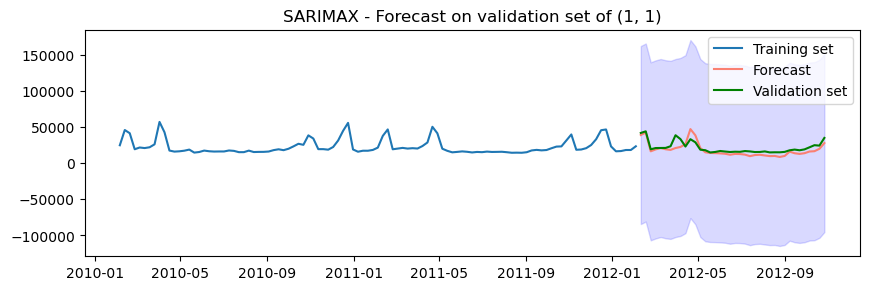

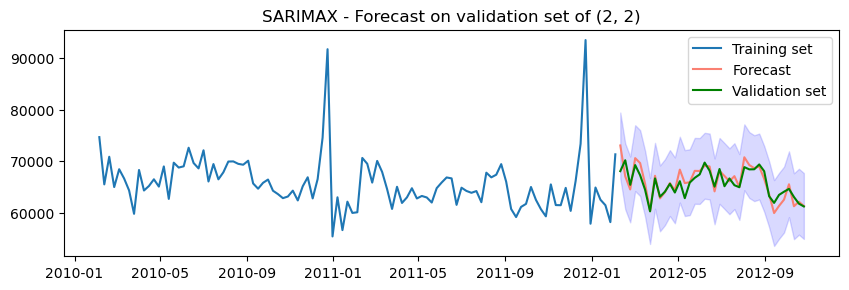

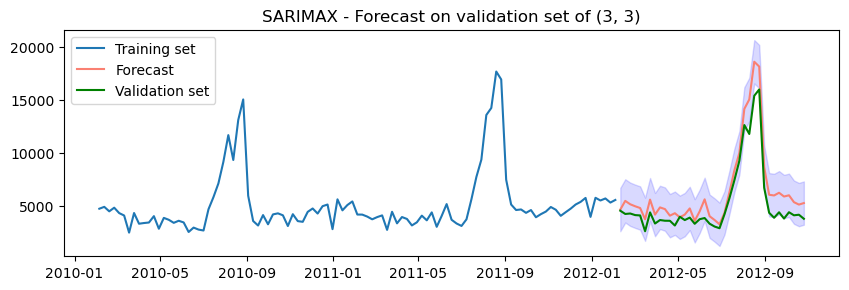

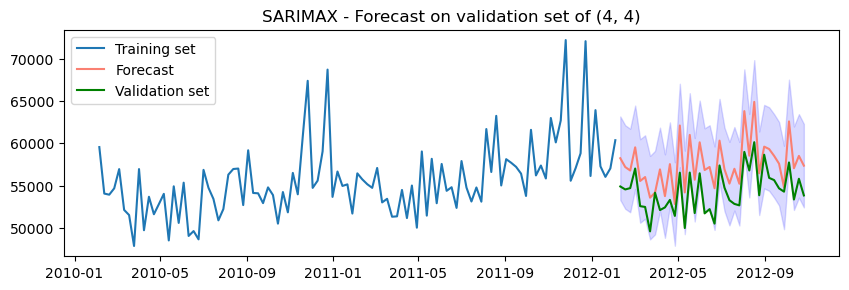

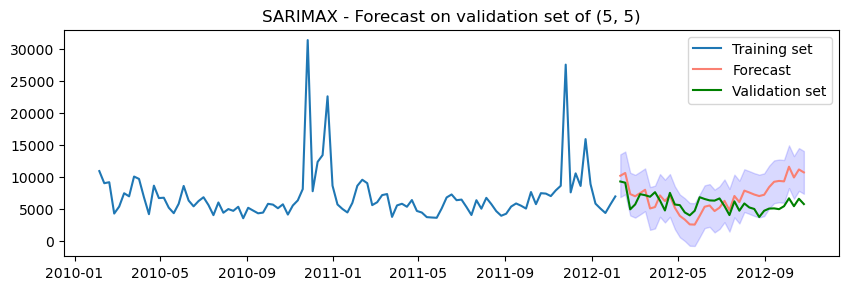

In [139]:
for isd, storedept in enumerate(list_store_dept):
    train = df_train_all2.loc[storedept,'Weekly_Sales']
    valid = df_valid_pred.loc[storedept,'Weekly_Sales']
    train_fc = sarimax_train_fc[isd]
    valid_fc = sarimax_valid_fc[isd]
    valid_fc_lower = sarimax_valid_fc_lower[isd]
    valid_fc_upper = sarimax_valid_fc_upper[isd]
    plot_forecast(storedept, train, train_fc, valid, valid_fc, valid_fc_lower, valid_fc_upper, 'SARIMAX')